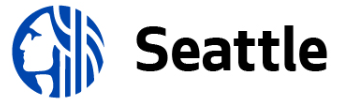

In [4]:
# add notebook summary
import jyquickhelper as jqh
from jyquickhelper import add_notebook_menu
add_notebook_menu(menu_id='OCDS_P4', raw=False, format='html',
                  header="Predict Buildings Energy Use - Feature pre-selection & EDA", first_level=1, last_level=5,
                  keep_item=None)

# Introduction - Load packages and check versions

In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FormatStrFormatter
import missingno as msno
from functions import *

from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
import scipy.stats as st

# configure transformers to output pandas DataFrames
# https://scikit-learn.org/1.5/auto_examples/miscellaneous/plot_set_output.html#sphx-glr-auto-examples-miscellaneous-plot-set-output-py
from sklearn import set_config
set_config(transform_output="pandas")

# serialization
import pickle

# set dataframe display options
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)

seattle_palette = ["#E0F2F1", "#B2EBE0", "#80DEDB", "#4DD0D9", "#26C6DA", "#00BFD8", "#00ACC1", "#0097A7", "#00838F", "#00796B",
                   "#00695C", "#004D40", "#A7D3E0", "#8AB8D6", "#74A8CC", "#5FA0C2", "#4B92B8", "#3E83AE", "#3175A4"]

# silence warnings after checking
import warnings
pd.set_option('future.no_silent_downcasting', False)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# 1 - EDA

## 1.1 - Import & describe dataset

In [5]:
raw_data = pd.read_csv('2016_Building_Energy_Benchmarking_20241006_web.csv')
print("Dataframe size:", raw_data.shape[0], "lines x ", raw_data.shape[1], "columns")
print("Nulls :", round((raw_data.isnull().sum().sum())*100/(raw_data.shape[0] * raw_data.shape[1]),2), "%")
raw_data.sample(5)

Dataframe size: 3376 lines x  46 columns
Nulls : 12.85 %


OSEBuildingID  DataYear          BuildingType   PrimaryPropertyType  \
2697          26667      2016        NonResidential                 Other   
2864          27252      2016  Multifamily MR (5-9)  Mid-Rise Multifamily   
1368          21646      2016  Multifamily LR (1-4)  Low-Rise Multifamily   
2563          26116      2016  Multifamily MR (5-9)  Mid-Rise Multifamily   
3338          50068      2016        NonResidential             Warehouse   

                                PropertyName            Address     City  \
2697                       Hillel Foundation  4745 17th Ave. NE  Seattle   
2864                              Greenhouse  3701 South Hudson  Seattle   
1368                              The Summit   733 Summit Ave E  Seattle   
2563                             Summit Arms    1512 Summit Ave  Seattle   
3338  Airport - Maintenance Shop - DOT: KCIA         6518 Ellis  Seattle   

     State  ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
2697    WA  98105.0                    8823901885                    4   
2864    WA  98118.0                    5649600172                    2   
1368    WA  98102.0                    2163900314                    3   
2563    WA  98122.0                    8804900880                    3   
3338    WA  98108.0                    2824049007                    2   

          Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
2697         NORTHEAST  47.66453 -122.30999       2004                1.0   
2864         SOUTHEAST  47.55681 -122.28579       2012                1.0   
1368              EAST  47.62586 -122.32576       1949                1.0   
2563              EAST  47.61465 -122.32552       1908                1.0   
3338  GREATER DUWAMISH  47.54425 -122.31776       1955                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
2697               2             21075                   0   
2864               5            121773               25568   
1368               3             44672                   0   
2563               5             27320                   0   
3338               1             52085                4222   

      PropertyGFABuilding(s)    ListOfAllPropertyUseTypes  \
2697                   21075  Office, Social/Meeting Hall   
2864                   96205          Multifamily Housing   
1368                   44672          Multifamily Housing   
2563                   27320          Multifamily Housing   
3338                   47863   Non-Refrigerated Warehouse   

          LargestPropertyUseType  LargestPropertyUseTypeGFA  \
2697         Social/Meeting Hall                    18075.0   
2864         Multifamily Housing                   121000.0   
1368         Multifamily Housing                    44672.0   
2563         Multifamily Housing                    27320.0   
3338  Non-Refrigerated Warehouse                    52085.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
2697                       Office                           3000.0   
2864                          NaN                              NaN   
1368                          NaN                              NaN   
2563                          NaN                              NaN   
3338                          NaN                              NaN   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
2697                         NaN                             NaN   
2864                         NaN                             NaN   
1368                         NaN                             NaN   
2563                         NaN                             NaN   
3338                         NaN                             NaN   

     YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
2697                      NaN              NaN         75.000000   
2864                      NaN             81.0         24.700001   
1368                     

<AxesSubplot: >

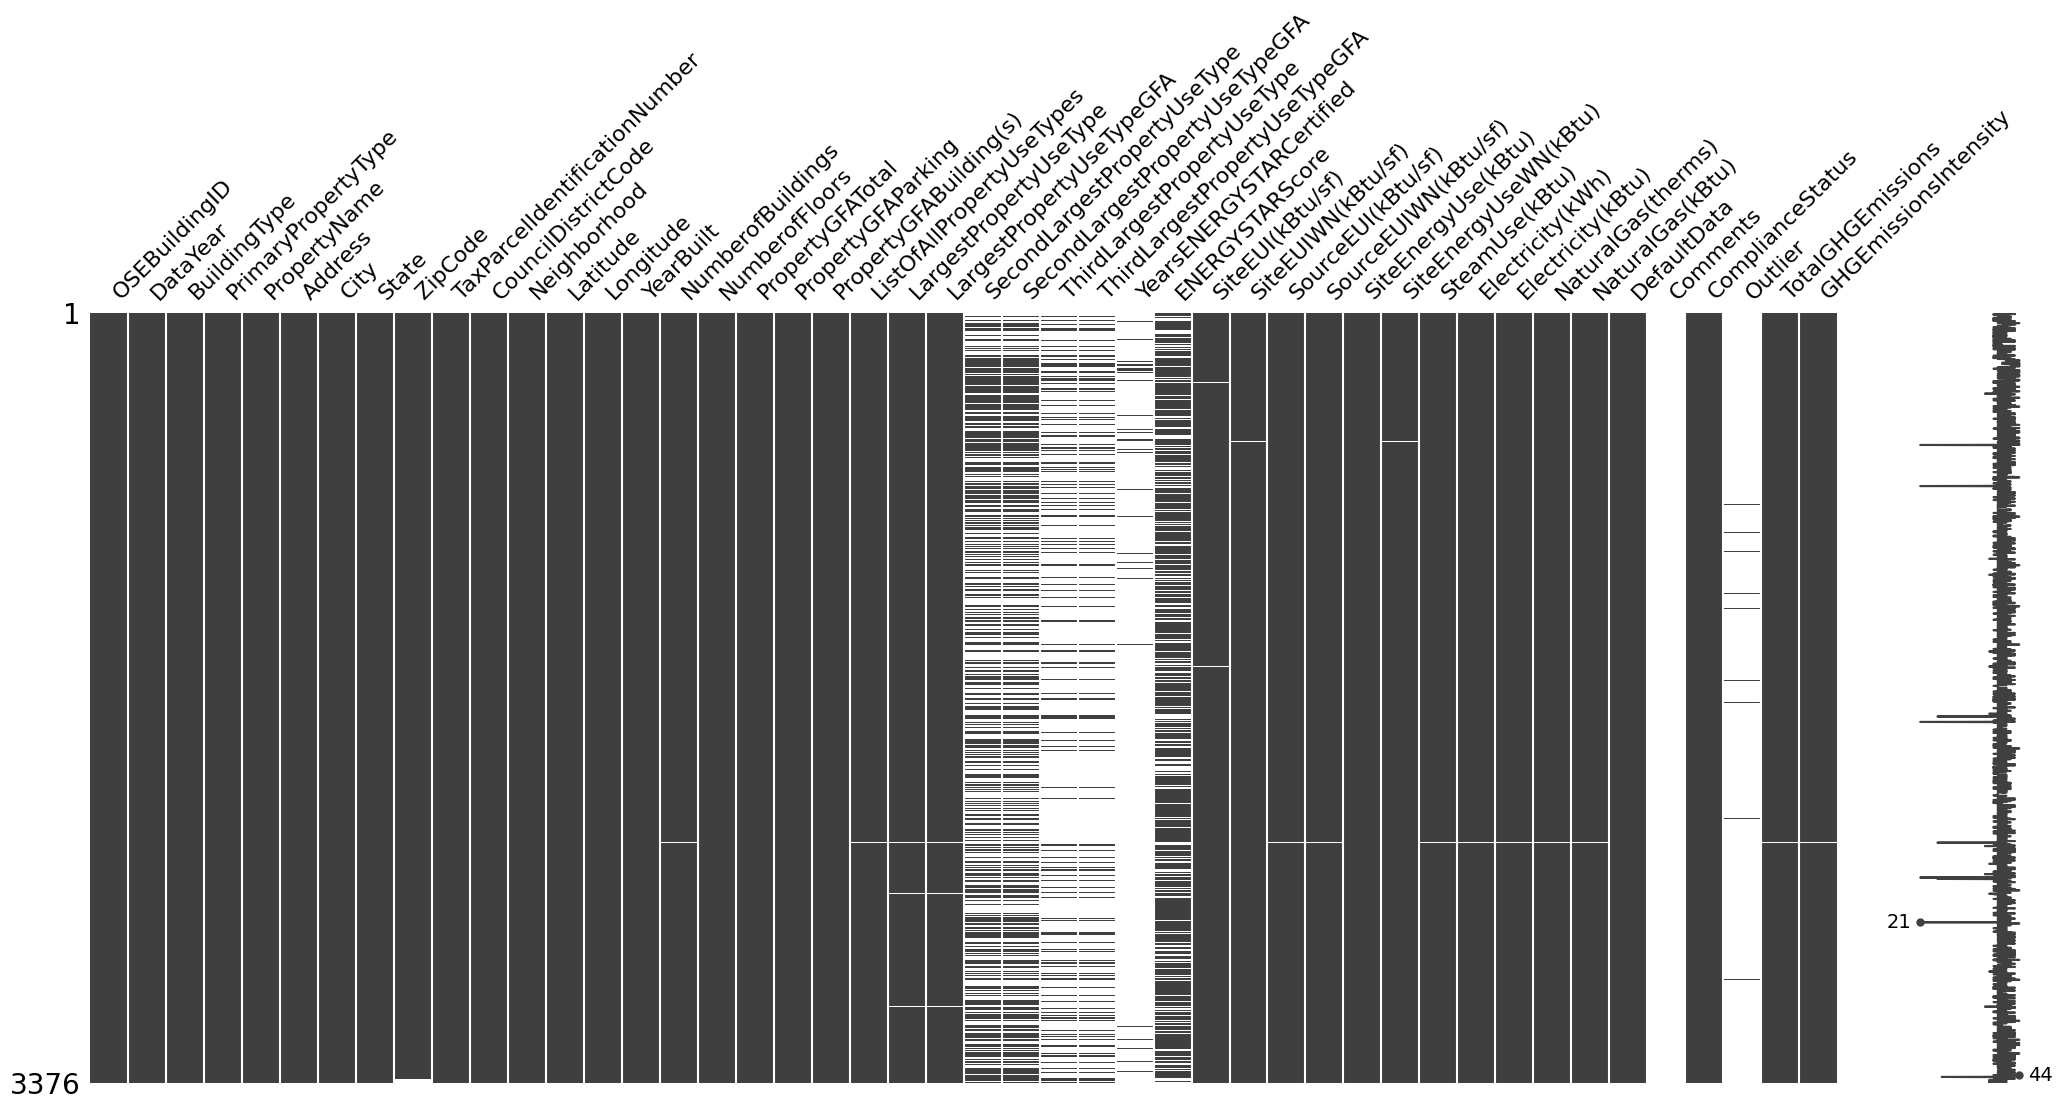

In [6]:
msno.matrix(raw_data)

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [8]:
raw_data.describe(include='number')

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3376.000000      3.376000e+03         3376.000000   
mean         4.709123      9.483354e+04         8001.526066   
std          5.494465      2.188376e+05        32326.723928   
min          0.000000      1.128500e+04            0.000000   
25%          2.000000      2.848700e+04            0.000000   
50%          4.000000      4.417500e+04            0.000000   
75%          5.000000      9.099200e+04            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            3.376000e+03               3.356000e+03   
mean             8.683201e+04               7.917764e+04   
std              2.079398e+05               2.017034e+05   
min              3.636000e+03               5.656000e+03   
25%              2.775600e+04               2.509475e+04   
50%              4.321600e+04               3.989400e+04   
75%              8.427625e+04               7.620025e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1679.000000                      596.000000   
mean                      28444.075817                    11738.675166   
std                       54392.917928                    29331.199286   
min                           0.000000                        0.000000   
25%                        5000.000000                     2239.000000   
50%                       10664.000000                     5043.000000   
75%                       26640.000000                    10138.750000   
max                      686750.000000                   459748.000000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count      2533.000000       3369.000000         3370.000000   
mean         67.918674         54.732116           57.033798   
std          26.873271         56.273124           57.163330   
min           1.000000          0.000000            0.000000   
25%          53.000000         27.900000           29.400000   
50%          75.000000         38.599998           40.900002   
75%          90.000000         60.400002           64.275002   
max         100.000000        834.400024          834.400024   

       SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
count         3367.000000           3367.000000         3.371000e+03   
mean           134.232848            137.783932         5.403667e+06   
std            139.287554            139.109807         2.161063e+07   
min              0.000000             -2.100000         0.000000e+00   
25%             74.699997             78.400002         9.251286e+05

In [9]:
nulls = raw_data.isna().sum().sum()/(raw_data.shape[0] * raw_data.shape[1])
print('total null % in dataframe :', round(nulls * 100, 2), '%')

total null % in dataframe : 12.85 %


In [100]:
dups = raw_data.duplicated().value_counts()
dups

False    3376
Name: count, dtype: int64

**No duplicates in data.**

## 1.2 - Data selection

### 1.2.1 - Pre-Select relevant rows - Non-residential buildings only

In [10]:
# inspect column BuildingType
raw_data['BuildingType'].value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [11]:
# inspect column PrimaryPropertyType
raw_data['PrimaryPropertyType'].value_counts()

PrimaryPropertyType
Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: count, dtype: int64

In [12]:
# inspect column LargestPropertyUseType
raw_data['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Multifamily Housing                                     1667
Office                                                   498
Non-Refrigerated Warehouse                               199
K-12 School                                              139
Other                                                    102
Retail Store                                              99
Hotel                                                     77
Worship Facility                                          71
Distribution Center                                       54
Senior Care Community                                     46
Supermarket/Grocery Store                                 41
Medical Office                                            41
Parking                                                   32
Other - Recreation                                        31
Self-Storage Facility                                     28
College/University                                        25
R

In [13]:
# remove all rows where BuildingType is not labelled as NonResidential% as well as all rows  where columns PrimaryPropertyType
# or LargestPropertyUseType contain the string 'Multifamily' or indicate other residential uses (dorms, prisons etc...)
# despite only rows containing the string 'Nonresidential' in column BuildingType being selected

list_out = ['Low-Rise Multifamily', 'Mid-Rise Multifamily', 'High-Rise Multifamily','Multifamily Housing',
        'Residential Care Facility', 'Residence Hall/Dormitory', 'Other - Lodging/Residential']

raw_data_1 = raw_data.loc[((raw_data['BuildingType']=='NonResidential')
                            |(raw_data['BuildingType']=='Nonresidential COS')
                            |(raw_data['BuildingType']=='Nonresidential WA'))
                         & (raw_data['PrimaryPropertyType'].isin(list_out)==False) 
                         & (raw_data['LargestPropertyUseType'].isin(list_out)==False)
                         & (raw_data['SecondLargestPropertyUseType'].isin(list_out)==False)
                         & (raw_data['ThirdLargestPropertyUseType'].isin(list_out)==False)
                         ].copy()

raw_data_1.shape

(1483, 46)

In [14]:
raw_data_1['PrimaryPropertyType'].value_counts()

PrimaryPropertyType
Small- and Mid-Sized Office    286
Other                          234
Warehouse                      186
Large Office                   169
Retail Store                    91
Mixed Use Property              87
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
K-12 School                     39
Self-Storage Facility           28
Senior Care Community           20
University                      18
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Office                           3
Name: count, dtype: int64

In [15]:
raw_data_1['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Office                                                  480
Non-Refrigerated Warehouse                              197
Retail Store                                             95
Other                                                    91
Hotel                                                    75
Worship Facility                                         71
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
K-12 School                                              39
Other - Recreation                                       31
Self-Storage Facility                                    27
Parking                                                  27
Other - Entertainment/Public Assembly                    20
Senior Care Community                                    20
College/University                                       18
Laboratory       

In [16]:
raw_data_1['City'].value_counts()

City
Seattle    1483
Name: count, dtype: int64

In [17]:
raw_data_1['State'].value_counts()

State
WA    1483
Name: count, dtype: int64

In [18]:
raw_data_1['TaxParcelIdentificationNumber'].nunique()

1411

In [19]:
raw_data_1['ZipCode'].nunique()

46

In [20]:
# remove columns with too little useful data or containing data irrelevant or unusable for analysis
raw_data_2 = raw_data_1[['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 
                             'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
                             'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 
                             'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
                             'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
                             'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                             'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
                             'Electricity(kBtu)', 'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus',
                             'Outlier', 'TotalGHGEmissions', 'GHGEmissionsIntensity']]
raw_data_2.shape

(1483, 35)

In [21]:
raw_data_2['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Office                                                  480
Non-Refrigerated Warehouse                              197
Retail Store                                             95
Other                                                    91
Hotel                                                    75
Worship Facility                                         71
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
K-12 School                                              39
Other - Recreation                                       31
Self-Storage Facility                                    27
Parking                                                  27
Other - Entertainment/Public Assembly                    20
Senior Care Community                                    20
College/University                                       18
Laboratory       

### 1.2.2 - Initial feature elimination

**The following columns were removed :**

**PropertyName :** unlikely to be useful for analysis  
**Address :** geolocation data preferred (latitude, Longitude & Neighborhood)  
**City :** unique value  
**State :** unique value  
**ZipCode :** geolocation data preferred (latitude, Longitude & Neighborhood)  
**TaxParcelIdentificationNumber :** unique identifier - unlikely to be useful for analysis  
**CouncilDistrictCode :** geolocation data preferred (latitude, Longitude & Neighborhood)  
**PropertyGFAParking :** replaced with PropertyGFAParking%  
**PropertyGFABuilding(s) :** replaced with PropertyGFABuilding(s)%  
**ListOfAllPropertyUseTypes :** multivariate field unlikely to be useful for analysis  
**YearsENERGYSTARCertified :** too many nulls  
**NaturalGas(therms) :** not a reporting unit for other energy sources (steam & electricity)  
**Comments :** empty column  

## 1.3 - Fix data quality issues

### 1.3.1 - Remove all rows where any default data was used in the reporting

In [22]:
# inspect column DefaultData
raw_data_2['DefaultData'].value_counts()

DefaultData
False    1470
True       13
Name: count, dtype: int64

In [23]:
# remove rows with data reporting quality issues (DefaultData=True)
raw_data_3 = raw_data_2.loc[raw_data_2['DefaultData']==False].copy()
raw_data_3.shape

(1470, 35)

### 1.3.2 - Remove rows with calculation errors in reported SiteEnergyUse(kBtu) > +/-5%

In [24]:
# eliminate further data reporting quality issues by removing lines where
# raw_data_4['SteamUse(kBtu)'] + raw_data_4['Electricity(kBtu)'] + raw_data_4['NaturalGas(kBtu)']
# deviates from raw_data_4['SiteEnergyUse(kBtu)] by more than 5%

raw_data_3['energy_use_check%'] = (abs(raw_data_3['SteamUse(kBtu)'] + raw_data_3['Electricity(kBtu)'] + raw_data_3['NaturalGas(kBtu)'] - raw_data_3['SiteEnergyUse(kBtu)']))/ raw_data_3['SiteEnergyUse(kBtu)']

raw_data_4 = raw_data_3.loc[raw_data_3['energy_use_check%'] < 0.05].copy()
raw_data_4.shape

(1449, 36)

### 1.3.3 - Remove rows where LargestPropertyUseTypeGFA is missing

In [25]:
raw_data_4 = raw_data_4.loc[raw_data_4['LargestPropertyUseTypeGFA'].isna()==False]
print(raw_data_4.shape)

(1445, 36)


In [26]:
raw_data_4['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Office                                                  467
Non-Refrigerated Warehouse                              195
Retail Store                                             89
Other                                                    85
Hotel                                                    75
Worship Facility                                         71
Distribution Center                                      54
Medical Office                                           41
Supermarket/Grocery Store                                40
K-12 School                                              39
Other - Recreation                                       31
Self-Storage Facility                                    27
Parking                                                  27
Senior Care Community                                    20
Other - Entertainment/Public Assembly                    20
College/University                                       16
Laboratory       

### 1.3.4 - Remove rows where NumberofBuildings is reported as zero

In [27]:
# check how many rows have obviously incorrect number of buildings
raw_data_4.loc[raw_data_4['NumberofBuildings'] == 0].shape

(48, 36)

**No common characteristics could be found for these buildings based on columns 'BuildingType', 'PrimaryPropertyType',
       'Neighborhood','YearBuilt', 'NumberofFloors', 'LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType','ENERGYSTARScore',  'ComplianceStatus', 'Outlier' and  'DefaultData', so the corresponding rows are droppped from the dataset.**

In [29]:
raw_data_4.drop(raw_data_4.loc[raw_data_4['NumberofBuildings']==0].index, inplace=True)
print(raw_data_4.shape)

(1397, 36)


### 1.3.5 - Incorrect labels in Neighborhood column

In [30]:
raw_data_4['Neighborhood'].value_counts()

Neighborhood
DOWNTOWN                  314
GREATER DUWAMISH          311
LAKE UNION                129
MAGNOLIA / QUEEN ANNE     128
EAST                      100
NORTHEAST                  96
NORTHWEST                  67
BALLARD                    54
NORTH                      47
CENTRAL                    40
DELRIDGE                   30
SOUTHWEST                  30
SOUTHEAST                  29
North                       7
Ballard                     5
Northwest                   4
Delridge                    3
Central                     2
DELRIDGE NEIGHBORHOODS      1
Name: count, dtype: int64

In [31]:
# replace irregularly labelled values in neighborhood column
raw_data_4.replace({'Neighborhood' : {'DELRIDGE NEIGHBORHOODS':'DELRIDGE'}}, regex=True, inplace=True)
raw_data_4['Neighborhood'] = raw_data_4['Neighborhood'].str.upper()
raw_data_4['Neighborhood'].value_counts()

Neighborhood
DOWNTOWN                 314
GREATER DUWAMISH         311
LAKE UNION               129
MAGNOLIA / QUEEN ANNE    128
EAST                     100
NORTHEAST                 96
NORTHWEST                 71
BALLARD                   59
NORTH                     54
CENTRAL                   42
DELRIDGE                  34
SOUTHWEST                 30
SOUTHEAST                 29
Name: count, dtype: int64

## 1.4 - Feature engineering

### 1.4.1 - Create building age column

In [32]:
# replace DataYear and YearBuilt with BuildingAge
raw_data_4['BuildingAge'] = raw_data_4['DataYear'] - raw_data_4['YearBuilt']
print(raw_data_4.shape)
raw_data_4.head()

(1397, 37)


OSEBuildingID  DataYear    BuildingType PrimaryPropertyType Neighborhood  \
0              1      2016  NonResidential               Hotel     DOWNTOWN   
1              2      2016  NonResidential               Hotel     DOWNTOWN   
2              3      2016  NonResidential               Hotel     DOWNTOWN   
3              5      2016  NonResidential               Hotel     DOWNTOWN   
4              8      2016  NonResidential               Hotel     DOWNTOWN   

   Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
0  47.61220 -122.33799       1927                1.0              12   
1  47.61317 -122.33393       1996                1.0              11   
2  47.61393 -122.33810       1969                1.0              41   
3  47.61412 -122.33664       1926                1.0              10   
4  47.61375 -122.34047       1980                1.0              18   

   PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0             88434                   0                   88434   
1            103566               15064                   88502   
2            956110              196718                  759392   
3             61320                   0                   61320   
4            175580               62000                  113580   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

   ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0             60.0         81.699997           84.300003          182.500000   
1             61.0         94.800003           97.900002          176.100006   
2             43.0         96.000000           97.699997          241.899994   
3             56.0        110.800003          113.300003          216.199997   
4             75.0        114.800003          118.699997          211.399994   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0            189.000000            7226362.5              7456910.0   
1            179.399994            8387933.0              8664479.0   
2            244.100006           72587024.0             73937112.0   
3            224.000000            6794584.0              6946800.5   
4            215.600006           14172606.0             14656503.0   

   SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(kBtu)  \
0      2003882.00      1.156514e+06          3946027.0         1276453.0   
1            0.00      9.504252e+05          3242851.0         5145082.0   
2     21566554.00      1.451544e+07         49526664.0         1493800.0   
3      2214446.25      8.115253e+05          2768924.0         1811213.0   
4            0.00      1.573449e+06          5368607.0         8803998.0   

   DefaultData ComplianceStatus Outlier  TotalGHGEmissions  \
0        False        Compliant     NaN             249.98   
1        False        Compliant     NaN             295.86   
2        False  

### 1.4.2 - Property use type ranks & corresponding GFAs as columns

In [33]:
# melt the df for usage types
melted_usage = pd.melt(raw_data_4, id_vars=['OSEBuildingID'],
                            value_vars=['LargestPropertyUseType', 
                                        'SecondLargestPropertyUseType', 
                                        'ThirdLargestPropertyUseType'], 
                            var_name='usage_rank', 
                            value_name='usage')

# order by ascending OSEBuildingID and usage_rank
melted_usage_sorted = melted_usage.sort_values(['OSEBuildingID', 'usage_rank'], ascending=[True, True])

# check result
print(melted_usage_sorted.shape)
melted_usage_sorted.head(6)

(4191, 3)


OSEBuildingID                    usage_rank       usage
0                 1        LargestPropertyUseType       Hotel
1397              1  SecondLargestPropertyUseType         NaN
2794              1   ThirdLargestPropertyUseType         NaN
1                 2        LargestPropertyUseType       Hotel
1398              2  SecondLargestPropertyUseType     Parking
2795              2   ThirdLargestPropertyUseType  Restaurant

In [34]:
# melt the df for GFA values
melted_gfa = pd.melt(raw_data_4, id_vars=['OSEBuildingID'],
                         value_vars=['LargestPropertyUseTypeGFA', 
                                     'SecondLargestPropertyUseTypeGFA', 
                                     'ThirdLargestPropertyUseTypeGFA'], 
                         var_name='gfa_rank', 
                         value_name='gfa')

# order by ascending OSEBuildingID and usage_rank
melted_gfa['use'] = melted_gfa['gfa_rank'].str[:-3]
melted_gfa_sorted = melted_gfa.sort_values(['OSEBuildingID', 'use'], ascending=[True, True])

# check result
print(melted_gfa_sorted.shape)
melted_gfa_sorted.head(6)

(4191, 4)


OSEBuildingID                         gfa_rank      gfa  \
0                 1        LargestPropertyUseTypeGFA  88434.0   
1397              1  SecondLargestPropertyUseTypeGFA      NaN   
2794              1   ThirdLargestPropertyUseTypeGFA      NaN   
1                 2        LargestPropertyUseTypeGFA  83880.0   
1398              2  SecondLargestPropertyUseTypeGFA  15064.0   
2795              2   ThirdLargestPropertyUseTypeGFA   4622.0   

                               use  
0           LargestPropertyUseType  
1397  SecondLargestPropertyUseType  
2794   ThirdLargestPropertyUseType  
1           LargestPropertyUseType  
1398  SecondLargestPropertyUseType  
2795   ThirdLargestPropertyUseType

In [35]:
# merge on OSEBuildingID and use/usage rank
combined_df = melted_usage.merge(melted_gfa, right_on=['OSEBuildingID','use'], left_on=['OSEBuildingID', 'usage_rank'],
                                 sort=True)

In [36]:
print(combined_df.shape)
combined_df.head(6)

(4191, 6)


OSEBuildingID                    usage_rank       usage  \
0              1        LargestPropertyUseType       Hotel   
1              1  SecondLargestPropertyUseType         NaN   
2              1   ThirdLargestPropertyUseType         NaN   
3              2        LargestPropertyUseType       Hotel   
4              2  SecondLargestPropertyUseType     Parking   
5              2   ThirdLargestPropertyUseType  Restaurant   

                          gfa_rank      gfa                           use  
0        LargestPropertyUseTypeGFA  88434.0        LargestPropertyUseType  
1  SecondLargestPropertyUseTypeGFA      NaN  SecondLargestPropertyUseType  
2   ThirdLargestPropertyUseTypeGFA      NaN   ThirdLargestPropertyUseType  
3        LargestPropertyUseTypeGFA  83880.0        LargestPropertyUseType  
4  SecondLargestPropertyUseTypeGFA  15064.0  SecondLargestPropertyUseType  
5   ThirdLargestPropertyUseTypeGFA   4622.0   ThirdLargestPropertyUseType

In [37]:
# pivot table
combined_df_trim = combined_df[['OSEBuildingID', 'usage', 'gfa']]
print(combined_df_trim.shape)
combined_df_trim_p = combined_df_trim.pivot_table(index=['OSEBuildingID'], columns=['usage'],
                                      values=['gfa']).droplevel(0, axis=1).reset_index()

(4191, 3)


In [38]:
# check result
print(combined_df_trim_p.shape)
combined_df_trim_p.sample(10)

(1397, 59)


usage  OSEBuildingID  Adult Education  Automobile Dealership  Bank Branch  \
974            23971              NaN                    NaN          NaN   
473              779              NaN                    NaN          NaN   
1265           27488              NaN                    NaN          NaN   
768            21495              NaN                    NaN          NaN   
975            23975              NaN                    NaN          NaN   
893            23076              NaN                    NaN          NaN   
1235           26883              NaN                    NaN          NaN   
166              361              NaN                    NaN          NaN   
1112           24958              NaN                    NaN          NaN   
662            20868              NaN                    NaN          NaN   

usage  Bar/Nightclub  College/University  \
974              NaN                 NaN   
473              NaN                 NaN   
1265             NaN                 NaN   
768              NaN                 NaN   
975              NaN                 NaN   
893              NaN                 NaN   
1235             NaN                 NaN   
166              NaN                 NaN   
1112             NaN                 NaN   
662              NaN                 NaN   

usage  Convenience Store without Gas Station  Courthouse  Data Center  \
974                                      NaN         NaN          NaN   
473                                      NaN         NaN          NaN   
1265                                     NaN         NaN          NaN   
768                                      NaN         NaN          NaN   
975                                      NaN         NaN          NaN   
893                                      NaN         NaN          NaN   
1235                                     NaN         NaN          NaN   
166                                      NaN         NaN          NaN   
1112                                     NaN         NaN          NaN   
662                                      NaN         NaN          NaN   

usage  Distribution Center  Enclosed Mall  Fast Food Restaurant  \
974                    NaN            NaN                   NaN   
473                    NaN            NaN                   NaN   
1265                   NaN            NaN                   NaN   
768                    NaN            NaN                   NaN   
975                    NaN            NaN                   NaN   
893                    NaN            NaN                   NaN   
1235                   NaN            NaN                   NaN   
166                    NaN            NaN                   NaN   
1112                   NaN            NaN                   NaN   
662                    NaN            NaN                   NaN   

usage  Financial Office  Fire Station  Fitness Center/Health Club/Gym  \
974                 NaN           NaN                             NaN   
473                 NaN           NaN                             NaN   
1265                NaN           NaN                             NaN   
768                 NaN           NaN                             NaN   
975                 NaN           NaN                             NaN   
893                 NaN           NaN                             NaN   
1235                NaN           NaN                             NaN   
166                 NaN           NaN                             NaN   
1112                NaN           NaN                             NaN   
662                 NaN           NaN                             NaN   

usage  Food Sales  Food Service  Hospital (General Medical & Surgical)  Hotel  \
974           NaN           NaN                                    NaN    NaN   
473           NaN           NaN                                    NaN    NaN   
1265          NaN           NaN                                    NaN    NaN 

**In order to limit the number of variables, we will remove all the buildings usage columns which have more than 99% NaNs and sum up the corresponding square footage in a new column 'Other_aggregated_usage'.**

In [39]:
# calculate total % of NaNs in resulting dataframe
print(round(combined_df_trim_p.isna().sum().sum()/(combined_df_trim_p.shape[0]*combined_df_trim_p.shape[1]),4)*100, " %")
# combined_df_trim_p.isna().sum().mean()/1397 # gives the same result

95.34  %


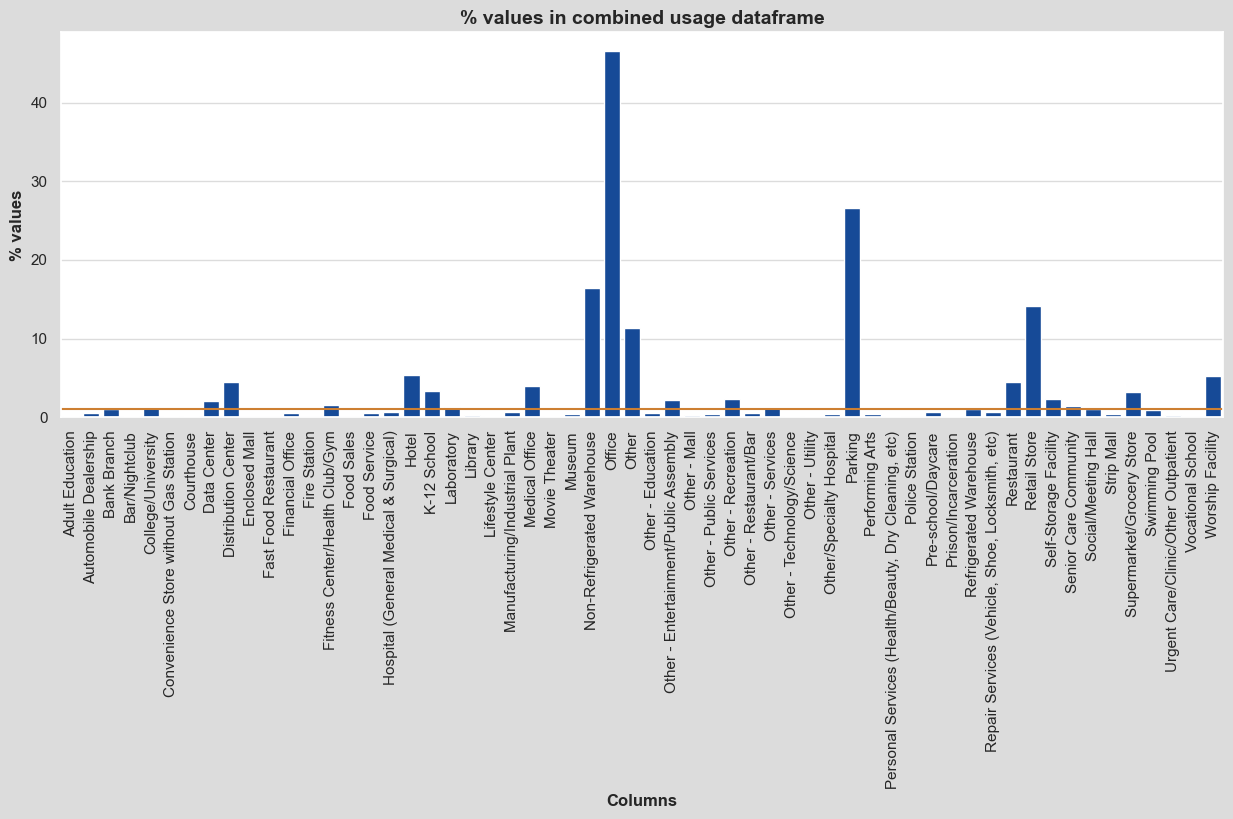

In [41]:
# plot % values
combined_not_nulls = pd.DataFrame(combined_df_trim_p.drop(labels='OSEBuildingID', axis=1).notnull().mean() * 100).reset_index()
combined_not_nulls.rename(columns={'usage': 'Column', 0: '% values'}, inplace = True)
sns.set(rc={'figure.figsize':(15, 5), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph143 = sns.barplot(data = combined_not_nulls, x='Column', y='% values', color='#0046AD')
plt.title('% values in combined usage dataframe', fontweight='bold', fontsize='14')
plt.xlabel('Columns', fontweight='bold', fontsize='12')
plt.xticks(rotation=90)
#plt.ylim(0,2)
plt.axhline(y=1, color='#CD7F32')
plt.ylabel('% values', fontweight='bold', fontsize='12')
plt.grid(axis='y', color='gainsboro')
plt.savefig("143.png", bbox_inches='tight')

In [42]:
cols_to_combine = combined_df_trim_p.columns[combined_df_trim_p.isnull().sum()/len(combined_df_trim_p) > .99]
cols_to_combine

Index(['Adult Education', 'Automobile Dealership', 'Bar/Nightclub',
       'Convenience Store without Gas Station', 'Courthouse', 'Enclosed Mall',
       'Fast Food Restaurant', 'Financial Office', 'Fire Station',
       'Food Sales', 'Food Service', 'Hospital (General Medical & Surgical)',
       'Library', 'Lifestyle Center', 'Manufacturing/Industrial Plant',
       'Movie Theater', 'Museum', 'Other - Education', 'Other - Mall',
       'Other - Public Services', 'Other - Restaurant/Bar',
       'Other - Technology/Science', 'Other - Utility',
       'Other/Specialty Hospital', 'Performing Arts',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Police Station', 'Pre-school/Daycare', 'Prison/Incarceration',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Strip Mall',
       'Swimming Pool', 'Urgent Care/Clinic/Other Outpatient',
       'Vocational School'],
      dtype='object', name='usage')

In [43]:
# replace all NaNs with 0
combined_df_trim_p.fillna(0, inplace=True)
combined_df_trim_p.head()

usage  OSEBuildingID  Adult Education  Automobile Dealership  Bank Branch  \
0                  1              0.0                    0.0          0.0   
1                  2              0.0                    0.0          0.0   
2                  3              0.0                    0.0          0.0   
3                  5              0.0                    0.0          0.0   
4                  8              0.0                    0.0          0.0   

usage  Bar/Nightclub  College/University  \
0                0.0                 0.0   
1                0.0                 0.0   
2                0.0                 0.0   
3                0.0                 0.0   
4                0.0                 0.0   

usage  Convenience Store without Gas Station  Courthouse  Data Center  \
0                                        0.0         0.0          0.0   
1                                        0.0         0.0          0.0   
2                                        0.0         0.0          0.0   
3                                        0.0         0.0          0.0   
4                                        0.0         0.0          0.0   

usage  Distribution Center  Enclosed Mall  Fast Food Restaurant  \
0                      0.0            0.0                   0.0   
1                      0.0            0.0                   0.0   
2                      0.0            0.0                   0.0   
3                      0.0            0.0                   0.0   
4                      0.0            0.0                   0.0   

usage  Financial Office  Fire Station  Fitness Center/Health Club/Gym  \
0                   0.0           0.0                             0.0   
1                   0.0           0.0                             0.0   
2                   0.0           0.0                             0.0   
3                   0.0           0.0                             0.0   
4                   0.0           0.0                             0.0   

usage  Food Sales  Food Service  Hospital (General Medical & Surgical)  \
0             0.0           0.0                                    0.0   
1             0.0           0.0                                    0.0   
2             0.0           0.0                                    0.0   
3             0.0           0.0                                    0.0   
4             0.0           0.0                                    0.0   

usage     Hotel  K-12 School  Laboratory  Library  Lifestyle Center  \
0       88434.0          0.0         0.0      0.0               0.0   
1       83880.0          0.0         0.0      0.0               0.0   
2      756493.0          0.0         0.0      0.0               0.0   
3       61320.0          0.0         0.0      0.0               0.0   
4      123445.0          0.0         0.0      0.0               0.0   

usage  Manufacturing/Industrial Plant  Medical Office  Movie Theater  Museum  \
0                                 0.0             0.0            0.0     0.0   
1                                 0.0             0.0            0.0     0.0   
2                                 0.0             0.0            0.0     0.0   
3                                 0.0             0.0            0.0     0.0   
4                                 0.0             0.0            0.0     0.0   

usage  Non-Refrigerated Warehouse  Office  Other  Other - Education  \
0                             0.0     0.0    0.0                0.0   
1                             0.0     0.0    0.0                0.0   
2                             0.0     0.0    0.0                0.0   
3                             0.0     0.0    0.0                0.0   
4                             0.0     0.0    0.0                0.0   

usage  Other - Entertainment/Public Assembly  Other - Mall  \
0                                        0.0           0.0   
1                                        0.0           0.0   
2                        

In [44]:
combined_df_trim_p['Other_aggregated_usage'] = combined_df_trim_p[cols_to_combine].sum(axis=1)
combined_df_trim_p.head()

usage  OSEBuildingID  Adult Education  Automobile Dealership  Bank Branch  \
0                  1              0.0                    0.0          0.0   
1                  2              0.0                    0.0          0.0   
2                  3              0.0                    0.0          0.0   
3                  5              0.0                    0.0          0.0   
4                  8              0.0                    0.0          0.0   

usage  Bar/Nightclub  College/University  \
0                0.0                 0.0   
1                0.0                 0.0   
2                0.0                 0.0   
3                0.0                 0.0   
4                0.0                 0.0   

usage  Convenience Store without Gas Station  Courthouse  Data Center  \
0                                        0.0         0.0          0.0   
1                                        0.0         0.0          0.0   
2                                        0.0         0.0          0.0   
3                                        0.0         0.0          0.0   
4                                        0.0         0.0          0.0   

usage  Distribution Center  Enclosed Mall  Fast Food Restaurant  \
0                      0.0            0.0                   0.0   
1                      0.0            0.0                   0.0   
2                      0.0            0.0                   0.0   
3                      0.0            0.0                   0.0   
4                      0.0            0.0                   0.0   

usage  Financial Office  Fire Station  Fitness Center/Health Club/Gym  \
0                   0.0           0.0                             0.0   
1                   0.0           0.0                             0.0   
2                   0.0           0.0                             0.0   
3                   0.0           0.0                             0.0   
4                   0.0           0.0                             0.0   

usage  Food Sales  Food Service  Hospital (General Medical & Surgical)  \
0             0.0           0.0                                    0.0   
1             0.0           0.0                                    0.0   
2             0.0           0.0                                    0.0   
3             0.0           0.0                                    0.0   
4             0.0           0.0                                    0.0   

usage     Hotel  K-12 School  Laboratory  Library  Lifestyle Center  \
0       88434.0          0.0         0.0      0.0               0.0   
1       83880.0          0.0         0.0      0.0               0.0   
2      756493.0          0.0         0.0      0.0               0.0   
3       61320.0          0.0         0.0      0.0               0.0   
4      123445.0          0.0         0.0      0.0               0.0   

usage  Manufacturing/Industrial Plant  Medical Office  Movie Theater  Museum  \
0                                 0.0             0.0            0.0     0.0   
1                                 0.0             0.0            0.0     0.0   
2                                 0.0             0.0            0.0     0.0   
3                                 0.0             0.0            0.0     0.0   
4                                 0.0             0.0            0.0     0.0   

usage  Non-Refrigerated Warehouse  Office  Other  Other - Education  \
0                             0.0     0.0    0.0                0.0   
1                             0.0     0.0    0.0                0.0   
2                             0.0     0.0    0.0                0.0   
3                             0.0     0.0    0.0                0.0   
4                             0.0     0.0    0.0                0.0   

usage  Other - Entertainment/Public Assembly  Other - Mall  \
0                                        0.0           0.0   
1                                        0.0           0.0   
2                        

In [45]:
# drop aggregated columns
combined_df_trim_p.drop(cols_to_combine, axis=1, inplace=True)

In [46]:
combined_df_trim_p_pct = raw_data_4[['OSEBuildingID','PropertyGFATotal']].merge(combined_df_trim_p, right_on=['OSEBuildingID'],
                                                                                left_on=['OSEBuildingID'], sort=False)
print(combined_df_trim_p_pct.shape)
combined_df_trim_p_pct.head()

(1397, 27)


OSEBuildingID  PropertyGFATotal  Bank Branch  College/University  \
0              1             88434          0.0                 0.0   
1              2            103566          0.0                 0.0   
2              3            956110          0.0                 0.0   
3              5             61320          0.0                 0.0   
4              8            175580          0.0                 0.0   

   Data Center  Distribution Center  Fitness Center/Health Club/Gym     Hotel  \
0          0.0                  0.0                             0.0   88434.0   
1          0.0                  0.0                             0.0   83880.0   
2          0.0                  0.0                             0.0  756493.0   
3          0.0                  0.0                             0.0   61320.0   
4          0.0                  0.0                             0.0  123445.0   

   K-12 School  Laboratory  Medical Office  Non-Refrigerated Warehouse  \
0          0.0         0.0             0.0                         0.0   
1          0.0         0.0             0.0                         0.0   
2          0.0         0.0             0.0                         0.0   
3          0.0         0.0             0.0                         0.0   
4          0.0         0.0             0.0                         0.0   

   Office  Other  Other - Entertainment/Public Assembly  Other - Recreation  \
0     0.0    0.0                                    0.0                 0.0   
1     0.0    0.0                                    0.0                 0.0   
2     0.0    0.0                                    0.0                 0.0   
3     0.0    0.0                                    0.0                 0.0   
4     0.0    0.0                                    0.0                 0.0   

   Other - Services  Parking  Refrigerated Warehouse  Restaurant  \
0               0.0      0.0                     0.0         0.0   
1               0.0  15064.0                     0.0      4622.0   
2               0.0      0.0                     0.0         0.0   
3               0.0      0.0                     0.0         0.0   
4               0.0  68009.0                     0.0         0.0   

   Retail Store  Self-Storage Facility  Senior Care Community  \
0           0.0                    0.0                    0.0   
1           0.0                    0.0                    0.0   
2           0.0                    0.0                    0.0   
3           0.0                    0.0                    0.0   
4           0.0                    0.0                    0.0   

   Social/Meeting Hall  Supermarket/Grocery Store  Worship Facility  \
0                  0.0                        0.0               0.0   
1                  0.0                        0.0               0.0   
2                  0.0                        0.0               0.0   
3                  0.0                        0.0               0.0   
4                  0.0                        0.0               0.0   

   Other_aggregated_usage  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0

In [47]:
# express property use type as % of total GFA
list = combined_df_trim_p_pct.columns[2:].tolist()
combined_df_trim_p_pct[list] = combined_df_trim_p_pct[list].div(combined_df_trim_p_pct['PropertyGFATotal'], axis=0)

In [48]:
raw_data_5 = raw_data_4.merge(combined_df_trim_p_pct, right_on=['OSEBuildingID'], left_on=['OSEBuildingID'])
print(raw_data_5.shape)

(1397, 63)


In [49]:
raw_data_5.sample(5)

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
480             784      2016  NonResidential                    Warehouse   
603           20168      2016  NonResidential                  K-12 School   
492             800      2016  NonResidential                 Retail Store   
1172          25844      2016  NonResidential                        Other   
1232          26761      2016  NonResidential  Small- and Mid-Sized Office   

          Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
480   GREATER DUWAMISH  47.58454 -122.32690       1960                1.0   
603           DOWNTOWN  47.61687 -122.33533       1995                1.0   
492           DELRIDGE  47.52222 -122.36892       1992                1.0   
1172  GREATER DUWAMISH  47.55523 -122.33448       1927                1.0   
1232        LAKE UNION  47.65373 -122.32721       2007                1.0   

      NumberofFloors  PropertyGFATotal_x  PropertyGFAParking  \
480                1               73296                   0   
603                3               22860                   0   
492                1              102500                   0   
1172               1               22622                   0   
1232               3               44510               18228   

      PropertyGFABuilding(s)          LargestPropertyUseType  \
480                    73296      Non-Refrigerated Warehouse   
603                    22860                     K-12 School   
492                   102500                    Retail Store   
1172                   22622  Manufacturing/Industrial Plant   
1232                   26282                          Office   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
480                     77800.0                      Parking   
603                     22860.0                          NaN   
492                     99471.0                      Parking   
1172                    23000.0                          NaN   
1232                    26282.0                      Parking   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
480                               0.0                         NaN   
603                               NaN                         NaN   
492                               0.0                         NaN   
1172                              NaN                         NaN   
1232                          18228.0                         NaN   

      ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
480                              NaN             83.0         30.299999   
603                              NaN             43.0         40.700001   
492                              NaN             81.0         73.400002   
1172                             NaN              NaN         33.700001   
1232                             NaN             23.0         83.300003   

      SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
480            34.799999           61.799999             66.699997   
603            43.299999          127.900002            136.100006   
492            77.699997          181.600006            185.500000   
1172           37.900002           64.000000             69.000000   
1232           85.599998          261.399994            268.899994   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
480          2.356377e+06           2.709055e+06             0.0   
603          9.311486e+05           9.905073e+05             0.0   
492          7.305474e+06           7.728856e+06             0.0   
1172         7.740757e+05           8.720143e+05             0.0   
1232         2.188051e+06           2.250450e+06             0.0   

      Electricity(kWh)  Electricity(kBtu)  NaturalGas(kBtu)  DefaultData  \
480       3.275430e+05          1117577.0         1238800.0        False   
603       2.729040e+05           931148.0               0.0        Fals

### 1.4.3 - Discretise target variables for stratified sampling

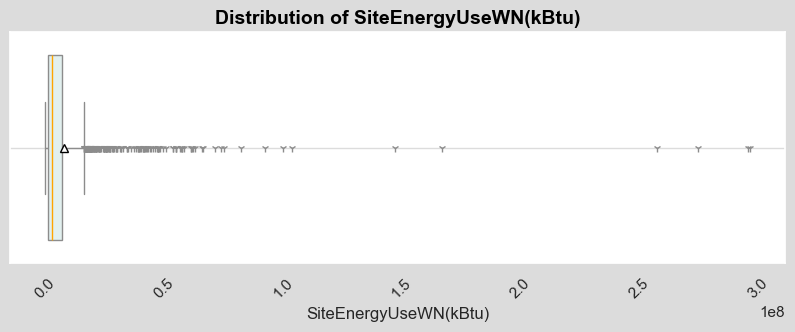

In [50]:
# find and analyse outliers in each numerical column
sns.set(rc={'figure.figsize':(10,3), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
data_graph143a = raw_data_5['SiteEnergyUseWN(kBtu)']
graph143a = sns.boxplot(data=data_graph143a, flierprops={"marker": "1"}, medianprops={"color" : "orange"}, 
                       meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="h", color='gold',
                       showmeans=True, dodge=False, palette=seattle_palette, legend=False)
plt.xticks(rotation=45)
plt.ylabel("", fontweight='bold', fontsize=12, color='black')
plt.title("Distribution of SiteEnergyUseWN(kBtu)",fontweight='bold', fontsize=14, color='black')
plt.grid(axis='y', color='gainsboro')
# plt.axvline(100, color=fuchsia)
plt.savefig("graph143a.png", bbox_inches='tight')
plt.show()

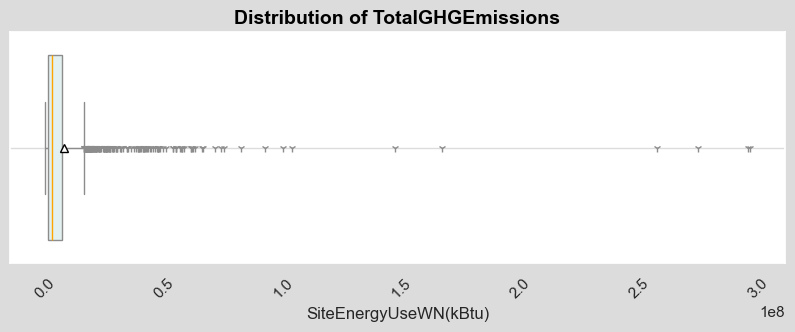

In [51]:
# find and analyse outliers in each numerical column
sns.set(rc={'figure.figsize':(10,3), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
data_graph143b = raw_data_5['TotalGHGEmissions']
graph143b = sns.boxplot(data=data_graph143a, flierprops={"marker": "1"}, medianprops={"color" : "orange"}, 
                       meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="h", color='gold',
                       showmeans=True, dodge=False, palette=seattle_palette, legend=False)
plt.xticks(rotation=45)
plt.ylabel("", fontweight='bold', fontsize=12, color='black')
plt.title("Distribution of TotalGHGEmissions",fontweight='bold', fontsize=14, color='black')
plt.grid(axis='y', color='gainsboro')
# plt.axvline(100, color=fuchsia)
plt.savefig("graph143b.png", bbox_inches='tight')
plt.show()

In [52]:
# discretise SiteEnergyUseWN(kBtu) and TotalGHGEmissions in low, medium & high bins
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile').set_output(transform="pandas")
binned_targets = discretizer.fit_transform(raw_data_5[['SiteEnergyUseWN(kBtu)','TotalGHGEmissions']])
binned_targets.rename(columns={'SiteEnergyUseWN(kBtu)':'SiteEnergyUseWN(kBtu)_bins', 'TotalGHGEmissions':'TotalGHGEmissions_bins'}, inplace=True)
binned_targets['SiteEnergyUseWN(kBtu)_bins'] = binned_targets['SiteEnergyUseWN(kBtu)_bins'].astype(int)
binned_targets['TotalGHGEmissions_bins'] = binned_targets['TotalGHGEmissions_bins'].astype(int)
binned_targets.replace(to_replace={'SiteEnergyUseWN(kBtu)_bins': { 0 : 'low', 1 : 'medium', 2 : 'high' }, 
                                  'TotalGHGEmissions_bins' :{ 0 : 'low', 1 : 'medium', 2 : 'high' } }, inplace=True)

In [53]:
raw_data_5 = pd.concat([raw_data_5, binned_targets], axis=1)
print(raw_data_5.shape)
raw_data_5.sample(5)

(1397, 65)


OSEBuildingID  DataYear    BuildingType    PrimaryPropertyType  \
47              70      2016  NonResidential                  Hotel   
853          22511      2016  NonResidential              Warehouse   
671          20970      2016  NonResidential  Senior Care Community   
746          21396      2016  NonResidential             Restaurant   
442            739      2016  NonResidential           Large Office   

              Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
47   MAGNOLIA / QUEEN ANNE  47.62023 -122.35951       1998                1.0   
853  MAGNOLIA / QUEEN ANNE  47.66206 -122.38948       1960                1.0   
671              SOUTHEAST  47.55387 -122.27875       1966                1.0   
746             LAKE UNION  47.62354 -122.33808       1919                1.0   
442             LAKE UNION  47.64912 -122.34823       2008                1.0   

     NumberofFloors  PropertyGFATotal_x  PropertyGFAParking  \
47                6              155602               36744   
853               1               56884                   0   
671               2               48882                7233   
746               3               40686                   0   
442               4              202623               88855   

     PropertyGFABuilding(s)      LargestPropertyUseType  \
47                   118858                       Hotel   
853                   56884  Non-Refrigerated Warehouse   
671                   41649       Senior Care Community   
746                   40686                  Restaurant   
442                  113768                      Office   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
47                    155602.0                          NaN   
853                    56884.0                          NaN   
671                    41922.0                      Parking   
746                    40686.0                          NaN   
442                   105206.0                      Parking   

     SecondLargestPropertyUseTypeGFA     ThirdLargestPropertyUseType  \
47                               NaN                             NaN   
853                              NaN                             NaN   
671                           9079.0                             NaN   
746                              NaN                             NaN   
442                          31992.0  Fitness Center/Health Club/Gym   

     ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
47                              NaN             81.0         43.900002   
853                             NaN             71.0         24.400000   
671                             NaN             51.0        161.800003   
746                             NaN              NaN         51.799999   
442                          6374.0             73.0         79.500000   

     SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
47            44.000000          107.400002            107.599998   
853           27.700001           54.500000             58.000000   
671          168.100006          304.899994            311.600006   
746           53.799999           97.599998             99.400002   
442           79.500000          249.699997            249.699997   

     SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
47           6836900.000             6849826.50             0.0   
853          1388345.125             1577967.75             0.0   
671          6782435.000             7048919.00             0.0   
746          2106073.500             2188575.25             0.0   
442          8873485.000             8873485.00             0.0   

     Electricity(kWh)  Electricity(kBtu)  NaturalGas(kBtu)  DefaultData  \
47       1.336148e+06          4558937.0         2277962.0        False   
853      2.302063e+05           785464.0          602881.0        False   
671      7.937441e+05          2708255.0         4074180.

### 1.4.4 - Add T/F columns for types of energy used

In [54]:
raw_data_5.loc[raw_data_5['SteamUse(kBtu)']!=0, 'UsesSteam'] = 1
raw_data_5.loc[raw_data_5['SteamUse(kBtu)']==0, 'UsesSteam'] = 0
raw_data_5.loc[raw_data_5['Electricity(kBtu)']!=0, 'UsesElectricity'] = 1
raw_data_5.loc[raw_data_5['Electricity(kBtu)']==0, 'UsesElectricity'] = 0
raw_data_5.loc[raw_data_5['NaturalGas(kBtu)']!=0, 'UsesGas'] = 1
raw_data_5.loc[raw_data_5['NaturalGas(kBtu)']==0, 'UsesGas'] = 0

In [55]:
print(raw_data_5.shape)
raw_data_5.sample(5)

(1397, 68)


OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
1160          25670      2016  NonResidential  Small- and Mid-Sized Office   
1346          49775      2016  NonResidential  Supermarket / Grocery Store   
137             330      2016  NonResidential  Small- and Mid-Sized Office   
1182          26040      2016  NonResidential        Self-Storage Facility   
690           21116      2016  NonResidential                        Other   

     Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
1160         EAST  47.61508 -122.31845       1906                1.0   
1346    SOUTHWEST  47.57984 -122.38577       2011                1.0   
137      DOWNTOWN  47.61356 -122.33665       1926                1.0   
1182     DELRIDGE  47.56785 -122.37039       1994                1.0   
690          EAST  47.61109 -122.32721       1920                1.0   

      NumberofFloors  PropertyGFATotal_x  PropertyGFAParking  \
1160               3               20897                   0   
1346               1               67263                   0   
137               10               63409                7757   
1182               3               66610                   0   
690                3               30971                   0   

      PropertyGFABuilding(s)     LargestPropertyUseType  \
1160                   20897                     Office   
1346                   67263  Supermarket/Grocery Store   
137                    55652                     Office   
1182                   66610      Self-Storage Facility   
690                    30971                      Other   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
1160                    10228.0                 Retail Store   
1346                    67263.0                          NaN   
137                     45260.0                 Retail Store   
1182                    66720.0                          NaN   
690                     30971.0                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
1160                           3433.0  Non-Refrigerated Warehouse   
1346                              NaN                         NaN   
137                            6187.0                         NaN   
1182                              NaN                         NaN   
690                               NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
1160                          3400.0              NaN         56.599998   
1346                             NaN             78.0        218.500000   
137                              NaN             90.0         66.900002   
1182                             NaN              NaN          9.600000   
690                              NaN              NaN         91.199997   

      SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
1160           60.500000          148.199997            152.300003   
1346          226.100006          517.500000            525.599976   
137            74.400002          131.699997            140.600006   
1182           11.100000           20.400000             22.000000   
690            96.000000          185.600006            195.399994   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
1160         9.649238e+05           1.031474e+06    0.000000e+00   
1346         1.469749e+07           1.521067e+07    0.000000e+00   
137          3.444270e+06           3.826622e+06    2.086425e+06   
1182         6.403770e+05           7.425715e+05    0.000000e+00   
690          2.823184e+06           2.974354e+06    2.309893e+05   

      Electricity(kWh)  Electricity(kBtu)  NaturalGas(kBtu)  DefaultData  \
1160      2.125565e+05           725243.0          239681.0        False   
1346      2.717600e+06          9272449.0         5425036.0        False   
137       3.979616e+05          1357845.0              

In [56]:
raw_data_5['UsesElectricity'].value_counts()

UsesElectricity
1.0    1396
0.0       1
Name: count, dtype: int64

In [57]:
no_elec = raw_data_5.loc[raw_data_5['UsesElectricity']==0]
no_elec

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType Neighborhood  \
340          23854      2016  NonResidential          Restaurant     DOWNTOWN   

     Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
340  47.60613 -122.34115       1900                1.0               1   

     PropertyGFATotal_x  PropertyGFAParking  PropertyGFABuilding(s)  \
340               43728                   0                   43728   

    LargestPropertyUseType  LargestPropertyUseTypeGFA  \
340             Restaurant                    43728.0   

    SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
340                          NaN                              NaN   

    ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
340                         NaN                             NaN   

     ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
340              NaN        263.200012          271.100006   

     SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
340          276.299988            284.600006           11508035.0   

     SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
340             11854450.0             0.0               0.0   

     Electricity(kBtu)  NaturalGas(kBtu)  DefaultData ComplianceStatus  \
340                0.0        11508035.0        False        Compliant   

    Outlier  TotalGHGEmissions  GHGEmissionsIntensity  energy_use_check%  \
340     NaN             611.19                  13.98                0.0   

     BuildingAge  PropertyGFATotal_y  Bank Branch  College/University  \
340          116               43728          0.0                 0.0   

     Data Center  Distribution Center  Fitness Center/Health Club/Gym  Hotel  \
340          0.0                  0.0                             0.0    0.0   

     K-12 School  Laboratory  Medical Office  Non-Refrigerated Warehouse  \
340          0.0         0.0             0.0                         0.0   

     Office  Other  Other - Entertainment/Public Assembly  Other - Recreation  \
340     0.0    0.0                                    0.0                 0.0   

     Other - Services  Parking  Refrigerated Warehouse  Restaurant  \
340               0.0      0.0                     0.0         1.0   

     Retail Store  Self-Storage Facility  Senior Care Community  \
340           0.0                    0.0                    0.0   

     Social/Meeting Hall  Supermarket/Grocery Store  Worship Facility  \
340                  0.0                        0.0               0.0   

     Other_aggregated_usage SiteEnergyUseWN(kBtu)_bins TotalGHGEmissions_bins  \
340                     0.0                       high                   high   

     UsesSteam  UsesElectricity  UsesGas  
340        0.0              0.0      1.0

**This building is evidently a reporting anomaly (a restaurant cannot operate without electricity) so we remove it.**

In [58]:
raw_data_5 = raw_data_5.loc[raw_data_5['UsesElectricity']!=0]
print(raw_data_5.shape)

(1396, 68)


### 1.4.5 - Add columns for % of total energy consumption by energy type

In [59]:
raw_data_5['TotalEnergyConsumption'] = raw_data_5['SteamUse(kBtu)'] + raw_data_5['Electricity(kBtu)'] + raw_data_5['NaturalGas(kBtu)']
raw_data_5['SteamUse_%'] = raw_data_5['SteamUse(kBtu)'] / raw_data_5['TotalEnergyConsumption']
raw_data_5['Electricity_%'] = raw_data_5['Electricity(kBtu)'] / raw_data_5['TotalEnergyConsumption']
raw_data_5['NaturalGas_%'] = raw_data_5['NaturalGas(kBtu)'] / raw_data_5['TotalEnergyConsumption']
print(raw_data_5.shape)
raw_data_5.sample(5)

(1396, 72)


OSEBuildingID  DataYear    BuildingType     PrimaryPropertyType  \
1271          27561      2016  NonResidential  Refrigerated Warehouse   
197             398      2016  NonResidential            Large Office   
665           20885      2016  NonResidential   Senior Care Community   
560           19845      2016  NonResidential            Retail Store   
1266          27494      2016  NonResidential     Distribution Center   

          Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
1271  GREATER DUWAMISH  47.56477 -122.32628       1961                1.0   
197           DOWNTOWN  47.61429 -122.35263       1916                1.0   
665            BALLARD  47.69875 -122.36725       1966                1.0   
560          NORTHEAST  47.66460 -122.29932       1996                1.0   
1266  GREATER DUWAMISH  47.53379 -122.33063       1979                1.0   

      NumberofFloors  PropertyGFATotal_x  PropertyGFAParking  \
1271               1               25577                   0   
197                6              350310                   0   
665                2               34636               31000   
560                1               25735                   0   
1266               1               36982                   0   

      PropertyGFABuilding(s)  LargestPropertyUseType  \
1271                   25577  Refrigerated Warehouse   
197                   350310                  Office   
665                     3636   Senior Care Community   
560                    25735            Retail Store   
1266                   36982     Distribution Center   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
1271                    13349.0   Non-Refrigerated Warehouse   
197                    305233.0           College/University   
665                     36000.0                      Parking   
560                     25691.0                          NaN   
1266                    34382.0                       Office   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
1271                           8228.0                      Office   
197                           26900.0                  Restaurant   
665                               0.0                         NaN   
560                               NaN                         NaN   
1266                           2600.0                         NaN   

      ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
1271                          4000.0              NaN         35.000000   
197                           7666.0             90.0         53.299999   
665                              NaN              3.0        337.500000   
560                              NaN             82.0         45.500000   
1266                             NaN              NaN         10.100000   

      SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
1271           34.500000           95.900002             94.000000   
197            53.299999          154.199997            154.199997   
665           355.700012          561.099976            587.900024   
560            48.500000          125.400002            128.500000   
1266           11.000000           26.600000             27.700001   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
1271         8.957847e+05           8.830729e+05             0.0   
197          1.810203e+07           1.810203e+07             0.0   
665          1.214872e+07           1.280571e+07             0.0   
560          1.169395e+06           1.245673e+06             0.0   
1266         3.747538e+05           4.058669e+05             0.0   

      Electricity(kWh)  Electricity(kBtu)  NaturalGas(kBtu)  DefaultData  \
1271      2.120948e+05           723667.0          172117.0        False   
197       4.681819e+06         15974366.0         2127656.0        False   
665       1.043779e+06          3561375.0         8587344.0        False 

## 1.6 - Outliers

In [60]:
# analyse outliers
outliers = raw_data_5.loc[raw_data_5['Outlier'].isna()==False]
print(outliers.shape)
outliers[['PrimaryPropertyType', 'NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseType',
          'SecondLargestPropertyUseType','ThirdLargestPropertyUseType','ENERGYSTARScore', 'Outlier', 'BuildingAge',
          'DefaultData','ComplianceStatus']]

(13, 72)


PrimaryPropertyType  NumberofBuildings  NumberofFloors  \
155                  Large Office                1.0               6   
300                  Retail Store                1.0               2   
415                  Large Office                1.0               4   
729   Small- and Mid-Sized Office                1.0               3   
767                         Other                1.0               3   
872              Worship Facility                1.0               1   
961   Small- and Mid-Sized Office                1.0               1   
1054                  K-12 School                1.0               2   
1086                        Other                1.0               3   
1097  Small- and Mid-Sized Office                1.0               2   
1147                        Hotel                1.0               3   
1244             Worship Facility                1.0               2   
1332                        Other                1.0               2   

     LargestPropertyUseType SecondLargestPropertyUseType  \
155                  Office                  Data Center   
300            Retail Store                        Other   
415                  Office                      Parking   
729                  Office                          NaN   
767                   Other                          NaN   
872        Worship Facility                          NaN   
961                  Office                          NaN   
1054            K-12 School                          NaN   
1086                  Other                      Parking   
1097                 Office                      Parking   
1147                  Hotel                          NaN   
1244       Worship Facility                          NaN   
1332                  Other                          NaN   

     ThirdLargestPropertyUseType  ENERGYSTARScore       Outlier  BuildingAge  \
155                      Parking              NaN  High outlier           58   
300                          NaN            100.0   Low outlier           29   
415                  Data Center              1.0  High outlier           16   
729                          NaN              NaN   Low outlier          113   
767                          NaN              NaN   Low outlier          116   
872                          NaN            100.0   Low outlier           45   
961                          NaN            100.0   Low outlier           69   
1054                         NaN            100.0   Low outlier           87   
1086                         NaN              NaN   Low outlier          106   
1097                         NaN            100.0   Low outlier          106   
1147                         NaN             99.0   Low outlier          116   
1244                         NaN            100.0   Low outlier           62   
1332                         NaN              NaN   Low outlier          110   

      DefaultData ComplianceStatus  
155         False    Non-Compliant  
300         False    Non-Compliant  
415         False    Non-Compliant  
729         False    Non-Compliant  
767         False    Non-Compliant  
872         False    Non-Compliant  
961         False    Non-Compliant  
1054        False    Non-Compliant  
1086        False    Non-Compliant  
1097        False    Non-Compliant  
1147        False    Non-Compliant  
1244        False    Non-Compliant  
1332        False    Non-Compliant

**Low outliers look suspicious from a data quality PoW (even though no default data has been used in their reporting) being old buildings > 40 YO (except 1) and yet having the best energy score star (100).
Given the relatively low number of outliers, they should be removed from the data.**

In [61]:
# remove all rows identified as outliers and remove column
raw_data_6 = raw_data_5.loc[raw_data_5['Outlier'].isna()==True].copy()

## 1.7 - Final feature selection

In [62]:
clean_data_all = raw_data_6.drop(columns=['DataYear', 'BuildingType', 'YearBuilt', 
                                          'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
                                          'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
                                          'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 
                                          'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                                          'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 
                                          'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier',
                                          'GHGEmissionsIntensity', 'energy_use_check%', 'PropertyGFATotal_x',
                                          'PropertyGFATotal_y', 'Parking', 'TotalEnergyConsumption'])

In [63]:
clean_data_all_bis = raw_data_6.drop(columns=['DataYear', 'BuildingType', 'YearBuilt', 
                                          'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
                                          'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
                                          'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 
                                          'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                                          'SiteEnergyUse(kBtu)', 'Electricity(kWh)', 'DefaultData', 'ComplianceStatus', 'Outlier',
                                          'GHGEmissionsIntensity', 'energy_use_check%', 'PropertyGFATotal_x',
                                          'PropertyGFATotal_y', 'Parking', 'TotalEnergyConsumption'])

**The following columns were further removed :**    
  
**DataYear :** same year for all buildings (2016), not relevant for analysis  
**BuildingType :** column dropped after selection of all non-residential building types  
**YearBuilt :** replaced with Building Age  
**LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA,            ThirdLargestPropertyUseType and ThirdLargestPropertyUseTypeGFA :** converted to usage type columns   
**SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf) and                                     SiteEnergyUse(kBtu) :** unsuitable target variables & unusable as features (colinearity with chosen targets)  
**Electricity(kWh) :** unusable as feature (colinearity with chosen targets)  
**SteamUse(kBtu),  Electricity(kBtu) and NaturalGas(kBtu) :** unusable as features (colinearity with chosen targets)  
**DefaultData :** column dropped after removal of all buildings using default data  
**ComplianceStatus :** indicated whether information was submitted before cutoff time as per Seattle Benchmarking Ordinance - irrelevant for analysis   
**Outlier :** column dropped after removal of outlier buildings  
**GHGEmissionsIntensity :** unsuitable target variable & unusable as feature (colinearity with chosen targets)  
**energy_use_check% :** column dropped after elimination of rows where check highlighted data quality issues  
**PropertyGFATotal_x, PropertyGFATotal_' and Parking:** duplicate columns  

In [64]:
print(clean_data_all.shape)
clean_data_all.head()

(1383, 45)


OSEBuildingID PrimaryPropertyType Neighborhood  Latitude  Longitude  \
0              1               Hotel     DOWNTOWN  47.61220 -122.33799   
1              2               Hotel     DOWNTOWN  47.61317 -122.33393   
2              3               Hotel     DOWNTOWN  47.61393 -122.33810   
3              5               Hotel     DOWNTOWN  47.61412 -122.33664   
4              8               Hotel     DOWNTOWN  47.61375 -122.34047   

   NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0                1.0              12                   0   
1                1.0              11               15064   
2                1.0              41              196718   
3                1.0              10                   0   
4                1.0              18               62000   

   PropertyGFABuilding(s)  ENERGYSTARScore  SiteEnergyUseWN(kBtu)  \
0                   88434             60.0              7456910.0   
1                   88502             61.0              8664479.0   
2                  759392             43.0             73937112.0   
3                   61320             56.0              6946800.5   
4                  113580             75.0             14656503.0   

   TotalGHGEmissions  BuildingAge  Bank Branch  College/University  \
0             249.98           89          0.0                 0.0   
1             295.86           20          0.0                 0.0   
2            2089.28           47          0.0                 0.0   
3             286.43           90          0.0                 0.0   
4             505.01           36          0.0                 0.0   

   Data Center  Distribution Center  Fitness Center/Health Club/Gym     Hotel  \
0          0.0                  0.0                             0.0  1.000000   
1          0.0                  0.0                             0.0  0.809918   
2          0.0                  0.0                             0.0  0.791220   
3          0.0                  0.0                             0.0  1.000000   
4          0.0                  0.0                             0.0  0.703070   

   K-12 School  Laboratory  Medical Office  Non-Refrigerated Warehouse  \
0          0.0         0.0             0.0                         0.0   
1          0.0         0.0             0.0                         0.0   
2          0.0         0.0             0.0                         0.0   
3          0.0         0.0             0.0                         0.0   
4          0.0         0.0             0.0                         0.0   

   Office  Other  Other - Entertainment/Public Assembly  Other - Recreation  \
0     0.0    0.0                                    0.0                 0.0   
1     0.0    0.0                                    0.0                 0.0   
2     0.0    0.0                                    0.0                 0.0   
3     0.0    0.0                                    0.0                 0.0   
4     0.0    0.0                                    0.0                 0.0   

   Other - Services  Refrigerated Warehouse  Restaurant  Retail Store  \
0               0.0                     0.0    0.000000           0.0   
1               0.0                     0.0    0.044629           0.0   
2               0.0                     0.0    0.000000           0.0   
3               0.0                     0.0    0.000000           0.0   
4               0.0                     0.0    0.000000           0.0   

   Self-Storage Facility  Senior Care Community  Social/Meeting Hall  \
0                    0.0                    0.0                  0.0   
1                    0.0                    0.0                  0.0   
2                    0.0                    0.0                  0.0   
3                    0.0                    0.0                  0.0   
4                    0.0                    0.0                  0.0   

   Supermarket/Grocery Store  Worship Facility  Other_aggregated_usage  \
0       

<AxesSubplot: >

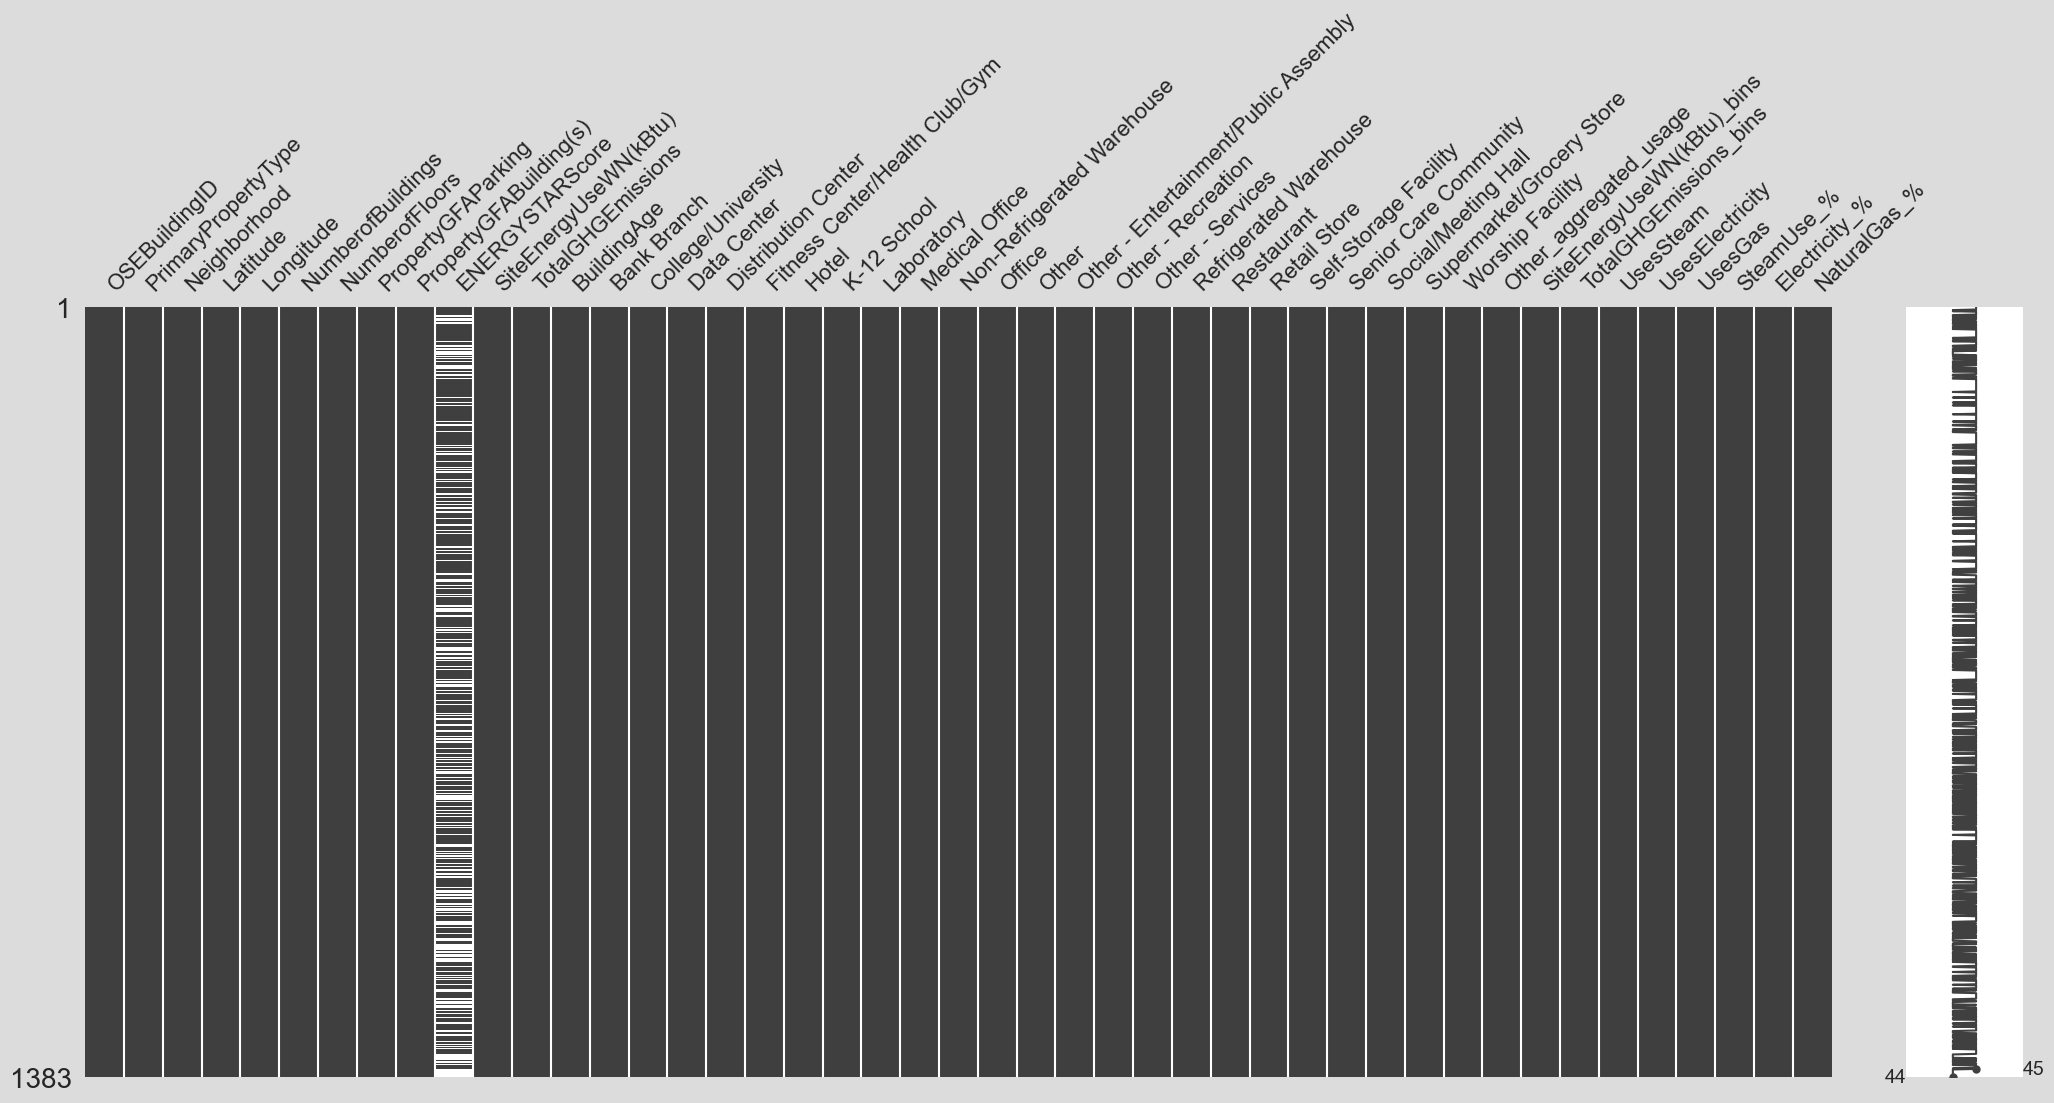

In [65]:
msno.matrix(clean_data_all)

In [66]:
# Typecasting & column names
clean_data_all['Neighborhood'] = clean_data_all['Neighborhood'].astype('category')
clean_data_all['UsesSteam'] = clean_data_all['UsesSteam'].astype(int, errors='ignore')
clean_data_all['UsesElectricity'] = clean_data_all['UsesElectricity'].astype(int, errors='ignore')
clean_data_all['UsesGas'] = clean_data_all['UsesGas'].astype(int, errors='ignore')
clean_data_all.rename(columns={'PropertyGFATotal_x': 'PropertyGFATotal'}, inplace = True)
clean_data_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1383 entries, 0 to 1396
Data columns (total 45 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   OSEBuildingID                          1383 non-null   int64   
 1   PrimaryPropertyType                    1383 non-null   object  
 2   Neighborhood                           1383 non-null   category
 3   Latitude                               1383 non-null   float64 
 4   Longitude                              1383 non-null   float64 
 5   NumberofBuildings                      1383 non-null   float64 
 6   NumberofFloors                         1383 non-null   int64   
 7   PropertyGFAParking                     1383 non-null   int64   
 8   PropertyGFABuilding(s)                 1383 non-null   int64   
 9   ENERGYSTARScore                        923 non-null    float64 
 10  SiteEnergyUseWN(kBtu)                  1383 non-null   float64 
 

# 1.8 - Univariate analyses

**Plot buildings on map of Seattle:**  
See https://www.ngs.noaa.gov/NCAT/ for coordinate conversion to WGS84

In [68]:
df3 = pd.read_csv('coords2.csv')
gps_data3 = df3[['Output_Lat(DD)','Output_Lon(DD)']]
gps_data3.head()

Output_Lat(DD)  Output_Lon(DD)
0       47.612197     -122.337993
1       47.613167     -122.333933
2       47.613927     -122.338103
3       47.614117     -122.336643
4       47.613747     -122.340473

In [70]:
BBox = ((gps_data3['Output_Lon(DD)'].min(), gps_data3['Output_Lon(DD)'].max(), gps_data3['Output_Lat(DD)'].min(), gps_data3['Output_Lat(DD)'].max()))
BBox

(-122.4142530752, -122.2209697732, 47.4991668987, 47.7338672616)

In [71]:
# Generate WGS84 map from https://www.openstreetmap.org with BBOx limits above
seattle_map = plt.imread('map_of_seattle_5.png')

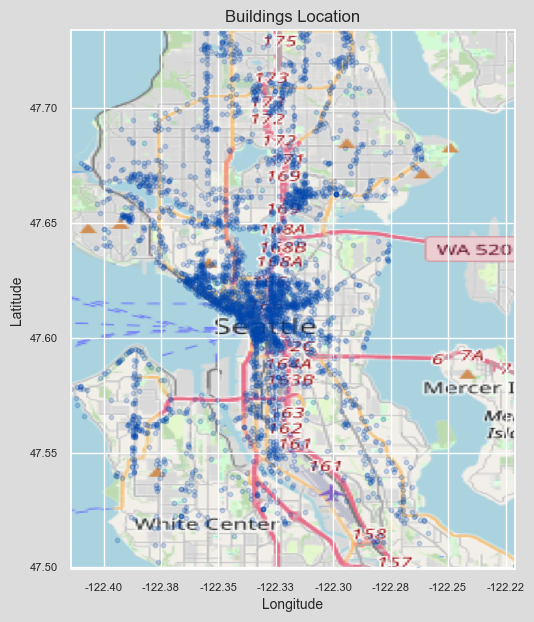

In [72]:
# plot buildings on map
fig, ax = plt.subplots(figsize = (15,7))
ax.scatter(x=gps_data3['Output_Lon(DD)'], y=gps_data3['Output_Lat(DD)'], zorder=1, alpha= 0.2, c='#0046AD', s=10)
ax.set_title('Buildings Location')
ax.tick_params(axis='x', labelrotation=0, labelsize=8)
ax.tick_params(axis='y', labelrotation=0, labelsize=8)
ax.set_xlabel("Longitude", fontsize=10)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_ylabel("Latitude", fontsize=10)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(seattle_map, zorder=0, extent = BBox, aspect= 'equal')
plt.savefig("buildings_location.png", bbox_inches='tight')

## 1.8.1 - Buildings by neigborhood

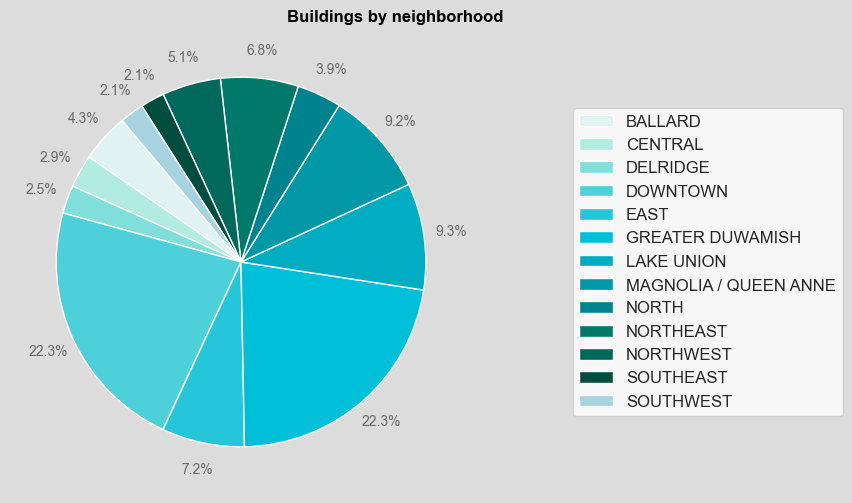

In [73]:
# plot pie by neighborhood
data_pie_1 = clean_data_all.groupby('Neighborhood')['OSEBuildingID'].count()
fig, ax = plt.subplots(figsize=(6,6))
fig.set_facecolor('gainsboro')
ax.pie(data_pie_1, radius=1, colors=seattle_palette, autopct = '%1.1f%%', pctdistance=1.15,
       wedgeprops=dict(edgecolor='w'), textprops={'fontsize': 10, 'color':'dimgray'},startangle=130)
ax.legend(title="", loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1), fontsize=12, 
          labels=data_pie_1.reset_index().Neighborhood)
plt.text(0.25, 1.3, "Buildings by neighborhood", fontsize=12, fontweight='bold', color='black')
plt.savefig("pie_1.png", bbox_inches='tight')
plt.show()

**Downtown and Greater Duwamish account each for over a fifth of the buildings in our data.**

## 1.8.2 - Buildings by age

In [74]:
# create age groups for buildings
data_with_ranges = clean_data_all.copy()
age_bins = [0, 20, 40, 60, 80, 100, 150]
age_bins_labels = ['0-20','20-40','40-60','60-80','80-100','>100', ]
data_with_ranges['age_group'] = pd.cut(data_with_ranges['BuildingAge'], bins=age_bins, labels=age_bins_labels, right=False)
data_with_ranges.head()

OSEBuildingID PrimaryPropertyType Neighborhood  Latitude  Longitude  \
0              1               Hotel     DOWNTOWN  47.61220 -122.33799   
1              2               Hotel     DOWNTOWN  47.61317 -122.33393   
2              3               Hotel     DOWNTOWN  47.61393 -122.33810   
3              5               Hotel     DOWNTOWN  47.61412 -122.33664   
4              8               Hotel     DOWNTOWN  47.61375 -122.34047   

   NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0                1.0              12                   0   
1                1.0              11               15064   
2                1.0              41              196718   
3                1.0              10                   0   
4                1.0              18               62000   

   PropertyGFABuilding(s)  ENERGYSTARScore  SiteEnergyUseWN(kBtu)  \
0                   88434             60.0              7456910.0   
1                   88502             61.0              8664479.0   
2                  759392             43.0             73937112.0   
3                   61320             56.0              6946800.5   
4                  113580             75.0             14656503.0   

   TotalGHGEmissions  BuildingAge  Bank Branch  College/University  \
0             249.98           89          0.0                 0.0   
1             295.86           20          0.0                 0.0   
2            2089.28           47          0.0                 0.0   
3             286.43           90          0.0                 0.0   
4             505.01           36          0.0                 0.0   

   Data Center  Distribution Center  Fitness Center/Health Club/Gym     Hotel  \
0          0.0                  0.0                             0.0  1.000000   
1          0.0                  0.0                             0.0  0.809918   
2          0.0                  0.0                             0.0  0.791220   
3          0.0                  0.0                             0.0  1.000000   
4          0.0                  0.0                             0.0  0.703070   

   K-12 School  Laboratory  Medical Office  Non-Refrigerated Warehouse  \
0          0.0         0.0             0.0                         0.0   
1          0.0         0.0             0.0                         0.0   
2          0.0         0.0             0.0                         0.0   
3          0.0         0.0             0.0                         0.0   
4          0.0         0.0             0.0                         0.0   

   Office  Other  Other - Entertainment/Public Assembly  Other - Recreation  \
0     0.0    0.0                                    0.0                 0.0   
1     0.0    0.0                                    0.0                 0.0   
2     0.0    0.0                                    0.0                 0.0   
3     0.0    0.0                                    0.0                 0.0   
4     0.0    0.0                                    0.0                 0.0   

   Other - Services  Refrigerated Warehouse  Restaurant  Retail Store  \
0               0.0                     0.0    0.000000           0.0   
1               0.0                     0.0    0.044629           0.0   
2               0.0                     0.0    0.000000           0.0   
3               0.0                     0.0    0.000000           0.0   
4               0.0                     0.0    0.000000           0.0   

   Self-Storage Facility  Senior Care Community  Social/Meeting Hall  \
0                    0.0                    0.0                  0.0   
1                    0.0                    0.0                  0.0   
2                    0.0                    0.0                  0.0   
3                    0.0                    0.0                  0.0   
4                    0.0                    0.0                  0.0   

   Supermarket/Grocery Store  Worship Facility  Other_aggregated_usage  \
0       

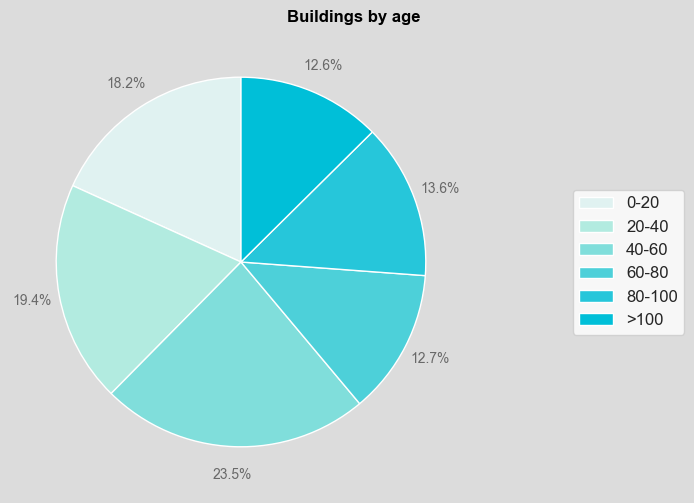

In [75]:
# plot pie by age of building
data_pie_2 = data_with_ranges.groupby('age_group')['OSEBuildingID'].count()
fig, ax = plt.subplots(figsize=(6,6))
fig.set_facecolor('gainsboro')
ax.pie(data_pie_2, radius=1, colors=seattle_palette, autopct = '%1.1f%%', pctdistance=1.15,
       wedgeprops=dict(edgecolor='w'), textprops={'fontsize': 10, 'color':'dimgray'},startangle=90)
ax.legend(title="", loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1), fontsize=12, 
          labels=data_pie_2.reset_index().age_group)
plt.text(0.25, 1.3, "Buildings by age", fontsize=12, fontweight='bold', color='black')
plt.savefig("pie_2.png", bbox_inches='tight')
plt.show()

**Recent buildings (less that 20YO) account for less than a fifth of non-residential real-estate, while old buildings (60YO and above) account for close to 40% of non-residential real-estate.**

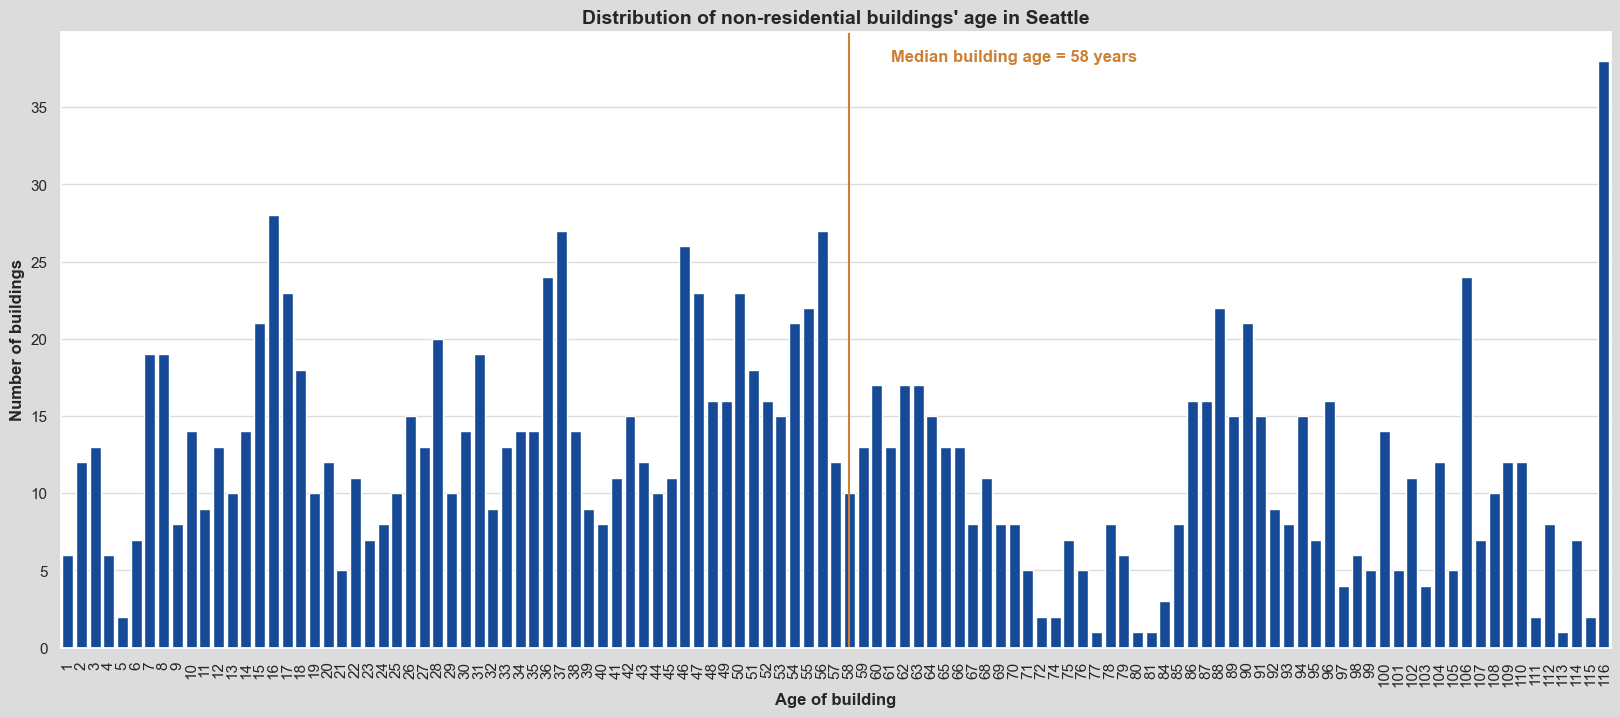

In [76]:
# bar chart of buildings by age
sns.set(rc={'figure.figsize':(20, 8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
data_2c = data_with_ranges['BuildingAge'].value_counts().reset_index()
graph_2c = sns.barplot(data=data_2c, x='BuildingAge', y='count', color='#0046AD')
plt.title("Distribution of non-residential buildings' age in Seattle", fontweight='bold', fontsize='14')
plt.xlabel('Age of building', fontweight='bold', fontsize='12')
plt.xticks(rotation=90)
plt.ylabel('Number of buildings', fontweight='bold', fontsize='12')
plt.axvline(x=data_2c['BuildingAge'].median(), color='#CD7F32')
plt.text(60, 38, 'Median building age = 58 years', fontweight='bold', fontsize='12', color='#CD7F32')
plt.grid(axis='y', color='gainsboro')
plt.savefig("graph_2c.png", bbox_inches='tight')

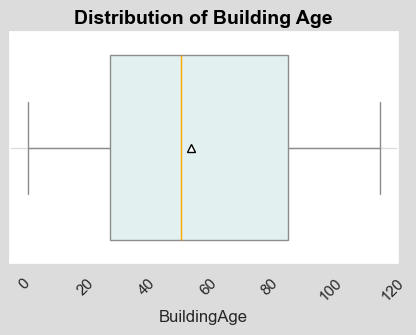

In [77]:
# fdistribution of buildings by age
sns.set(rc={'figure.figsize':(5,3), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
data_graph2b = clean_data_all['BuildingAge']
graph6 = sns.boxplot(data=data_graph2b, flierprops={"marker": "1"}, medianprops={"color" : "orange"}, 
                       meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="h", color='gold',
                       showmeans=True, dodge=False, palette=seattle_palette, legend=False)
plt.xticks(rotation=45)
plt.ylabel("", fontweight='bold', fontsize=12, color='black')
plt.title("Distribution of Building Age",fontweight='bold', fontsize=14, color='black')
plt.grid(axis='y', color='gainsboro')
plt.savefig("graph2b.png", bbox_inches='tight')
plt.show()

**It is worth noting the significant number of centenarian buildings (189, i.e. slightly over 13%).**

## 1.8.3 - Buildings by number of floors

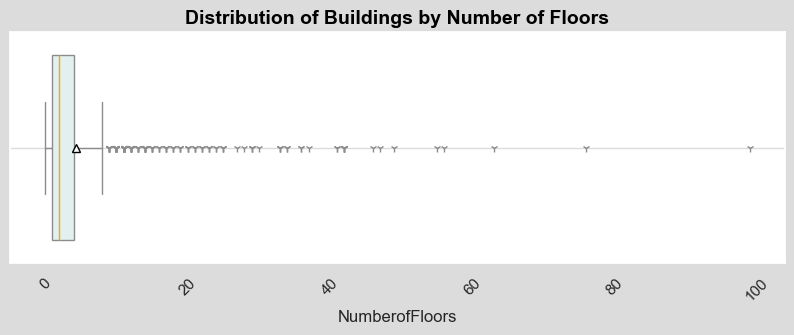

In [78]:
# distribution of buildings by number of floors
sns.set(rc={'figure.figsize':(10,3), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
data_graph2b = clean_data_all['NumberofFloors']
graph6 = sns.boxplot(data=data_graph2b, flierprops={"marker": "1"}, medianprops={"color" : "orange"}, 
                       meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="h", color='gold',
                       showmeans=True, dodge=False, palette=seattle_palette, legend=False)
plt.xticks(rotation=45)
plt.ylabel("", fontweight='bold', fontsize=12, color='black')
plt.title("Distribution of Buildings by Number of Floors",fontweight='bold', fontsize=14, color='black')
plt.grid(axis='y', color='gainsboro')
plt.savefig("graph1133a.png", bbox_inches='tight')
plt.show()

In [79]:
# create number of floors groups for buildings
floor_bins = [0, 1, 10, 20, 100]
floor_bins_labels = ['Ground level only','Up to 10 floors','Up to 20 floors','Over 20 floors']
data_with_ranges['floor_group'] = pd.cut(data_with_ranges['NumberofFloors'], bins=floor_bins, labels=floor_bins_labels,
                                         right=True)
data_with_ranges.head(1)

OSEBuildingID PrimaryPropertyType Neighborhood  Latitude  Longitude  \
0              1               Hotel     DOWNTOWN   47.6122 -122.33799   

   NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0                1.0              12                   0   

   PropertyGFABuilding(s)  ENERGYSTARScore  SiteEnergyUseWN(kBtu)  \
0                   88434             60.0              7456910.0   

   TotalGHGEmissions  BuildingAge  Bank Branch  College/University  \
0             249.98           89          0.0                 0.0   

   Data Center  Distribution Center  Fitness Center/Health Club/Gym  Hotel  \
0          0.0                  0.0                             0.0    1.0   

   K-12 School  Laboratory  Medical Office  Non-Refrigerated Warehouse  \
0          0.0         0.0             0.0                         0.0   

   Office  Other  Other - Entertainment/Public Assembly  Other - Recreation  \
0     0.0    0.0                                    0.0                 0.0   

   Other - Services  Refrigerated Warehouse  Restaurant  Retail Store  \
0               0.0                     0.0         0.0           0.0   

   Self-Storage Facility  Senior Care Community  Social/Meeting Hall  \
0                    0.0                    0.0                  0.0   

   Supermarket/Grocery Store  Worship Facility  Other_aggregated_usage  \
0                        0.0               0.0                     0.0   

  SiteEnergyUseWN(kBtu)_bins TotalGHGEmissions_bins  UsesSteam  \
0                       high                   high          1   

   UsesElectricity  UsesGas  SteamUse_%  Electricity_%  NaturalGas_%  \
0                1        1    0.277302        0.54606      0.176638   

  age_group      floor_group  
0    80-100  Up to 20 floors

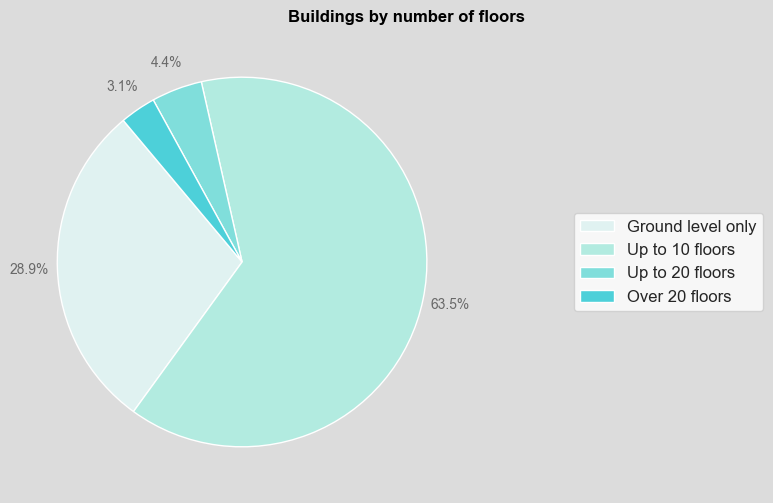

In [80]:
# plot pie by number of floors
data_pie_3 = data_with_ranges.groupby('floor_group')['OSEBuildingID'].count()
fig, ax = plt.subplots(figsize=(6,6))
fig.set_facecolor('gainsboro')
ax.pie(data_pie_3, radius=1, colors=seattle_palette, autopct = '%1.1f%%', pctdistance=1.15,
       wedgeprops=dict(edgecolor='w'), textprops={'fontsize': 10, 'color':'dimgray'},startangle=130)
ax.legend(title="", loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1), fontsize=12, 
          labels=floor_bins_labels)
plt.text(0.25, 1.3, "Buildings by number of floors", fontsize=12, fontweight='bold', color='black')
plt.savefig("pie_3.png", bbox_inches='tight')
plt.show()

## 1.8.4 - Buildings by primary property type

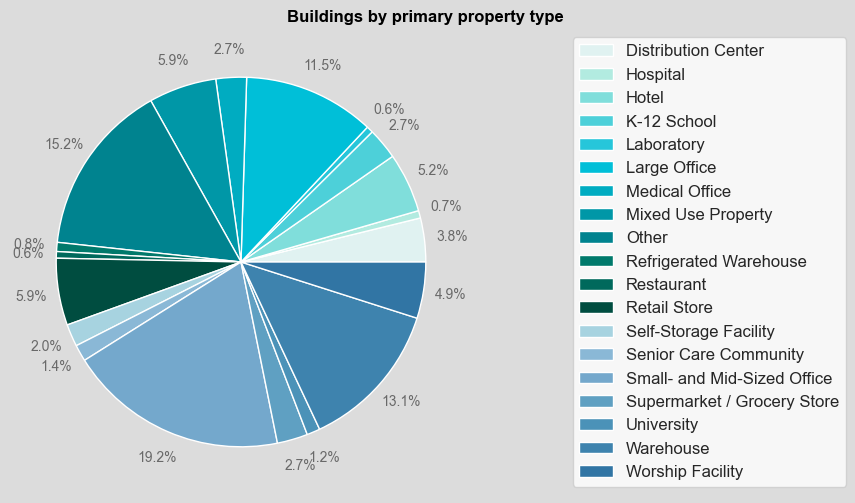

In [81]:
# plot pie by primary property type
data_pie_4 = clean_data_all.groupby('PrimaryPropertyType')['OSEBuildingID'].count()
fig, ax = plt.subplots(figsize=(6,6))
fig.set_facecolor('gainsboro')
ax.pie(data_pie_4, radius=1, colors=seattle_palette, autopct = '%1.1f%%', pctdistance=1.15,
       wedgeprops=dict(edgecolor='w'), textprops={'fontsize': 10, 'color':'dimgray'},startangle=0)
ax.legend(title="", loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1), fontsize=12, 
          labels=data_pie_4.reset_index().PrimaryPropertyType)
plt.text(0.25, 1.3, "Buildings by primary property type", fontsize=12, fontweight='bold', color='black')
plt.savefig("pie_4.png", bbox_inches='tight')
plt.show()

**Most non-residential real-estate is used for offices and warehouses.**

## 1.8.5 - Buildings by energy source used

In [82]:
# create boolean column for each type of energy used
data_with_ranges.loc[(data_with_ranges['UsesSteam']==1) & (data_with_ranges['UsesElectricity']==0) 
                     & (data_with_ranges['UsesGas']==0) , 'Only Steam'] = 1
data_with_ranges.loc[(data_with_ranges['UsesSteam']==0) & (data_with_ranges['UsesElectricity']==1) 
                     & (data_with_ranges['UsesGas']==0), 'Only Electricity'] = 1
data_with_ranges.loc[(data_with_ranges['UsesSteam']==0) & (data_with_ranges['UsesElectricity']==0) 
                     & (data_with_ranges['UsesGas']==1), 'Only Gas'] = 1
data_with_ranges.loc[(data_with_ranges['UsesSteam']==1) & (data_with_ranges['UsesElectricity']==0) 
                     & (data_with_ranges['UsesGas']==1), 'Steam and Gas'] = 1
data_with_ranges.loc[(data_with_ranges['UsesSteam']==1) & (data_with_ranges['UsesElectricity']==1) 
                     & (data_with_ranges['UsesGas']==0), 'Steam and Electricity'] = 1
data_with_ranges.loc[(data_with_ranges['UsesSteam']==0) & (data_with_ranges['UsesElectricity']==1) 
                     & (data_with_ranges['UsesGas']==1), 'Gas and Electricity'] = 1
data_with_ranges.loc[(data_with_ranges['UsesSteam']==1) & (data_with_ranges['UsesElectricity']==1) 
                     & (data_with_ranges['UsesGas']==1), 'All 3'] = 1

In [83]:
# create data for pie
not_nans = data_with_ranges[['Only Electricity', 'Only Gas', 'Steam and Electricity',
                            'Gas and Electricity', 'All 3']].count().reset_index()
not_nans.rename(columns={'index': 'Energy Source', 0:'Number of Buildings'},inplace=True)
not_nans

Energy Source  Number of Buildings
0       Only Electricity                  359
1               Only Gas                    0
2  Steam and Electricity                   45
3    Gas and Electricity                  924
4                  All 3                   55

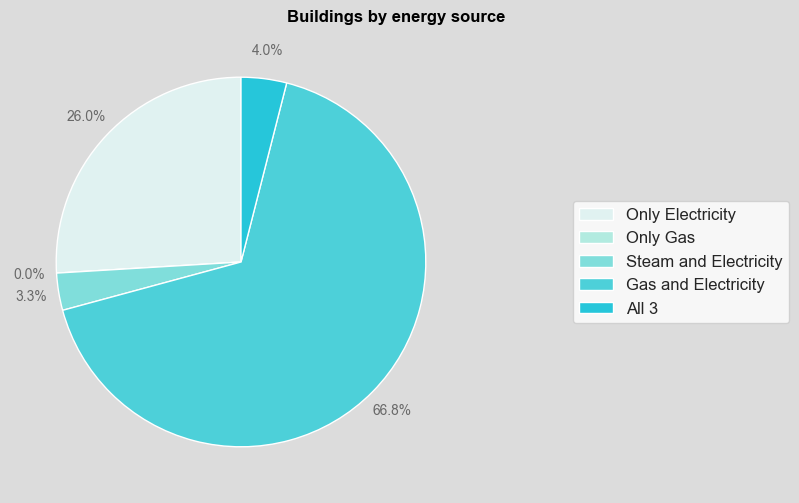

In [84]:
# plot pie by energy source
data_pie_5 = not_nans
fig, ax = plt.subplots(figsize=(6,6))
fig.set_facecolor('gainsboro')
ax.pie(data_pie_5['Number of Buildings'], radius=1, colors=seattle_palette, autopct = '%1.1f%%', pctdistance=1.15,
       wedgeprops=dict(edgecolor='w'), textprops={'fontsize': 10, 'color':'dimgray'},startangle=90)
ax.legend(title="", loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1), fontsize=12, 
          labels=data_pie_5['Energy Source'])
plt.text(0.25, 1.3, "Buildings by energy source", fontsize=12, fontweight='bold', color='black')
plt.savefig("pie_5.png", bbox_inches='tight')
plt.show()

## 1.8.6 - Buildings by number of buildings

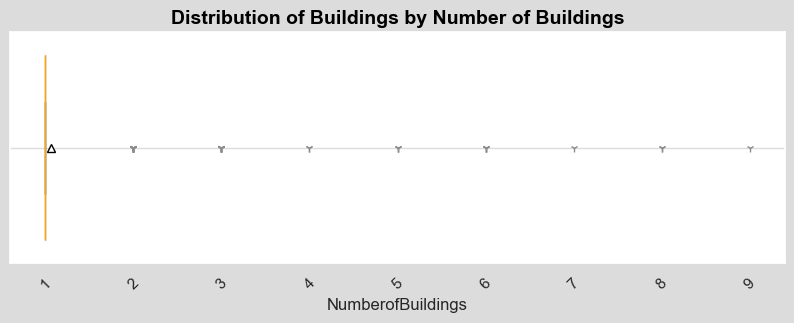

In [85]:
# fdistribution of buildings by number of buildings in complex
sns.set(rc={'figure.figsize':(10,3), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
data_graph6a = clean_data_all['NumberofBuildings']
graph6a = sns.boxplot(data=data_graph6a, flierprops={"marker": "1"}, medianprops={"color" : "orange"}, 
                       meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, orient="h", color='gold',
                       showmeans=True, dodge=False, palette=seattle_palette, legend=False)
plt.xticks(rotation=45)
plt.ylabel("", fontweight='bold', fontsize=12, color='black')
plt.title("Distribution of Buildings by Number of Buildings",fontweight='bold', fontsize=14, color='black')
plt.grid(axis='y', color='gainsboro')
plt.savefig("graph1136a.png", bbox_inches='tight')
plt.show()

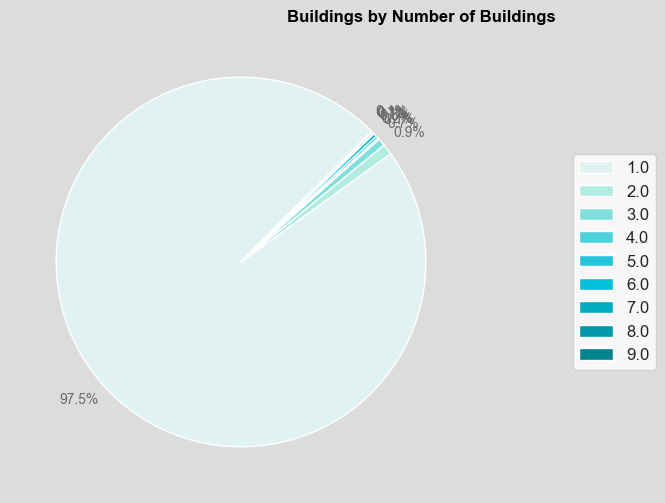

In [86]:
# plot pie by number of buildings in complex
data_pie_6 = clean_data_all.groupby('NumberofBuildings')['OSEBuildingID'].count()
fig, ax = plt.subplots(figsize=(6,6))
fig.set_facecolor('gainsboro')
ax.pie(data_pie_6, radius=1, colors=seattle_palette, autopct = '%1.1f%%', pctdistance=1.15,
       wedgeprops=dict(edgecolor='w'), textprops={'fontsize': 10, 'color':'dimgray'},startangle=45)
ax.legend(title="", loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1), fontsize=12, 
          labels=data_pie_6.reset_index().NumberofBuildings)
plt.text(0.25, 1.3, "Buildings by Number of Buildings", fontsize=12, fontweight='bold', color='black')
plt.savefig("pie_1136b.png", bbox_inches='tight')
plt.show()

**The vast majority of compounds (>95%) comprise only 1 building.**

## 1.8.7 - Buildings by Energy Star Score

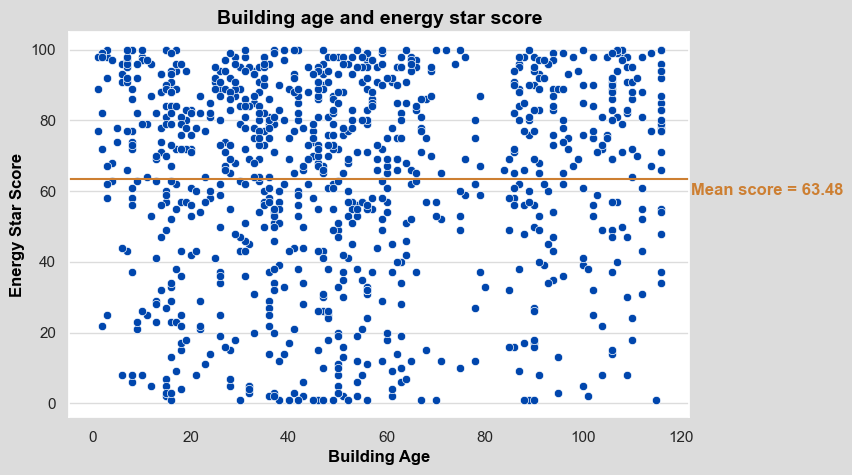

In [88]:
# plot age of buildings vs. energy star score
fig, ax = plt.subplots(figsize=(8,5))
fig.set_facecolor('gainsboro')
data_scatter1 = clean_data_all.loc[clean_data_all['ENERGYSTARScore'].isna()==False]
sns.scatterplot(data=data_scatter1, x='BuildingAge', y='ENERGYSTARScore', color='#0046AD')
plt.title('Energy Star Score and non-residential building age')
plt.xticks(rotation=0)
plt.axhline(y=data_scatter1['ENERGYSTARScore'].mean(), color='#CD7F32')
plt.text(122, 59, 'Mean score = ' + round(data_scatter1['ENERGYSTARScore'].mean(),2).astype(str), fontweight='bold', fontsize='12', color='#CD7F32')
plt.xlabel("Building Age", fontweight='bold', fontsize=12, color='black')
plt.ylabel("Energy Star Score", fontweight='bold', fontsize=12, color='black')
plt.title("Building age and energy star score",fontweight='bold', fontsize=14, color='black')
plt.grid(axis='y', color='gainsboro')
plt.savefig("scatter_1.png", bbox_inches='tight')
plt.show()

# 1.9 - Bivariate analyses

### 1.9.1 - Distribution & skewness analysis

In [89]:
# create smaller dataframe for clearer heatmap visualisation
data_pairs = data_scatter1.drop(labels=['PrimaryPropertyType', 'Neighborhood', 'OSEBuildingID','Bank Branch', 
                                           'College/University', 'Data Center', 'Distribution Center', 
                                           'Fitness Center/Health Club/Gym', 'Hotel', 'K-12 School', 'Laboratory',
                                           'Medical Office', 'Non-Refrigerated Warehouse', 'Office', 'Other',
                                           'Other - Entertainment/Public Assembly', 'Other - Recreation', 'Other - Services',
                                           'Refrigerated Warehouse', 'Restaurant', 'Retail Store', 'Self-Storage Facility',
                                           'Senior Care Community', 'Social/Meeting Hall', 'Supermarket/Grocery Store',
                                           'Worship Facility', 'Other_aggregated_usage', 'SiteEnergyUseWN(kBtu)_bins',
                                          'TotalGHGEmissions_bins','UsesSteam', 'UsesElectricity', 'UsesGas'], axis=1)
data_pairs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 923 entries, 0 to 1381
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Latitude                923 non-null    float64
 1   Longitude               923 non-null    float64
 2   NumberofBuildings       923 non-null    float64
 3   NumberofFloors          923 non-null    int64  
 4   PropertyGFAParking      923 non-null    int64  
 5   PropertyGFABuilding(s)  923 non-null    int64  
 6   ENERGYSTARScore         923 non-null    float64
 7   SiteEnergyUseWN(kBtu)   923 non-null    float64
 8   TotalGHGEmissions       923 non-null    float64
 9   BuildingAge             923 non-null    int64  
 10  SteamUse_%              923 non-null    float64
 11  Electricity_%           923 non-null    float64
 12  NaturalGas_%            923 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 101.0 KB


In [90]:
# perform Kolmogorov-Smirnov test to check in variables follow Gaussian distribution and skew test
# to check for significant skew requiring correction in pipeline pre-processing steps
for column in data_pairs:
    print('********\n{}'.format(column))
    mu = data_pairs[column].mean()
    sigma = data_pairs[column].std()
    normed_column = (data_pairs[column] - mu) / sigma
    stat_ks, p_ks = st.kstest(normed_column, 'norm')
    stat_st, p_st = st.skewtest(data_pairs[column])
    
    alpha = 0.05
    print("\n Kolmogorov-Smirnov test results : \n")
    print("Statistic = {:.4f}".format(stat_ks))
    print("p-value = {:.4f}".format(p_ks))
    if p_ks < alpha:  # null hypothesis: column follows a Normal distribution
        print("Reject H0 : {} does not follow a normal distribution".format(column))
    else:
        print("Not enough information to reject H0: {} follows a normal distribution. ".format(column))
        
    print("\n Skew test results : \n")
    print("Statistic = {:.4f}".format(stat_st))
    print("p-value = {:.4f}".format(p_st))
    if p_st < alpha:  # null hypothesis: column skew is the same as a Normal distribution (about zero)
        print("Reject H0 : {} skew is not zero".format(column))
    else:
        print("Not enough information to reject H0: {} skew is zero.".format(column))

********
Latitude

 Kolmogorov-Smirnov test results : 

Statistic = 0.1008
p-value = 0.0000
Reject H0 : Latitude does not follow a normal distribution

 Skew test results : 

Statistic = 2.9865
p-value = 0.0028
Reject H0 : Latitude skew is not zero
********
Longitude

 Kolmogorov-Smirnov test results : 

Statistic = 0.0996
p-value = 0.0000
Reject H0 : Longitude does not follow a normal distribution

 Skew test results : 

Statistic = 0.1178
p-value = 0.9062
Not enough information to reject H0: Longitude skew is zero.
********
NumberofBuildings

 Kolmogorov-Smirnov test results : 

Statistic = 0.5250
p-value = 0.0000
Reject H0 : NumberofBuildings does not follow a normal distribution

 Skew test results : 

Statistic = 35.1910
p-value = 0.0000
Reject H0 : NumberofBuildings skew is not zero
********
NumberofFloors

 Kolmogorov-Smirnov test results : 

Statistic = 0.3023
p-value = 0.0000
Reject H0 : NumberofFloors does not follow a normal distribution

 Skew test results : 

Statistic = 2

**Distribution test results indicate use of Spearman's Rho would be appropriate for correlation analysis. Skew analysis indicates the application of PowerTransformer would be appropriate before application of non-ensemble regression models.**

### 1.9.2 - Correlation analysis

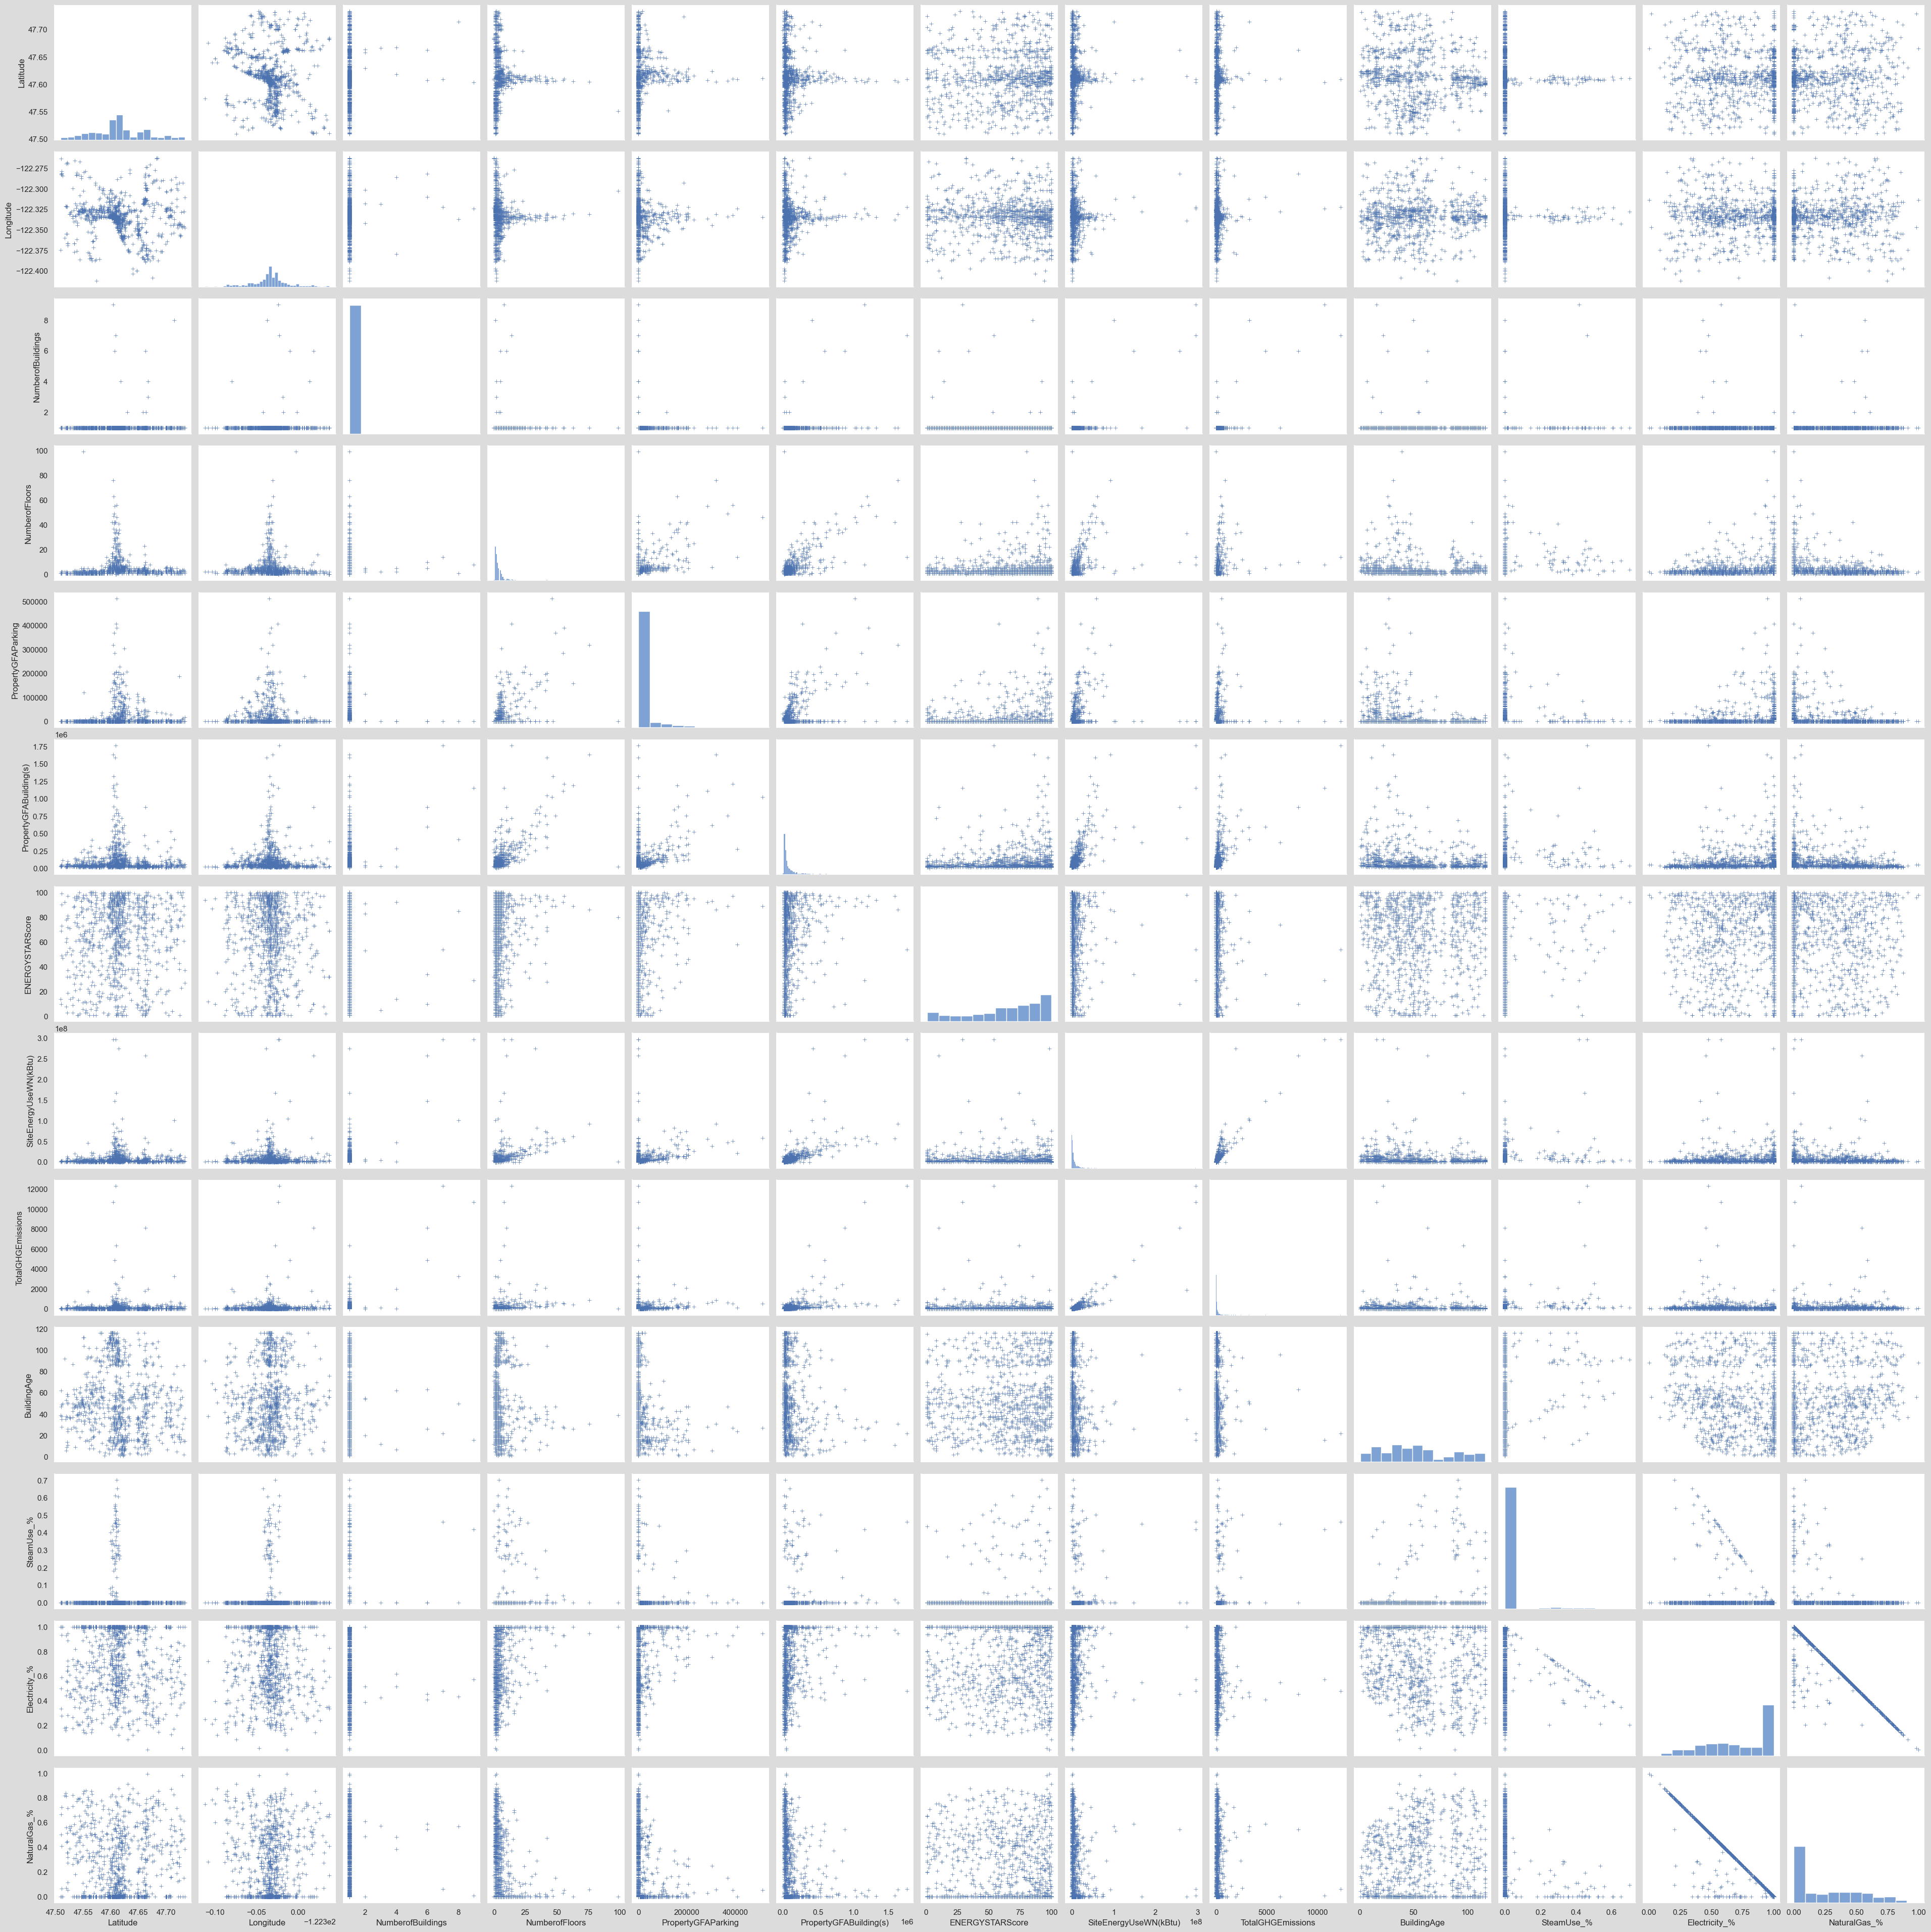

In [91]:
# compare correlation of continuous numerical variables in a pairplot
corr_pairs = sns.pairplot(data_pairs, kind='scatter', height=3, diag_kind='hist', 
                          markers="+", diag_kws= {'color': '#0046AD', 'alpha': 0.5})      
plt.savefig("data_pairplot.png")
plt.show()

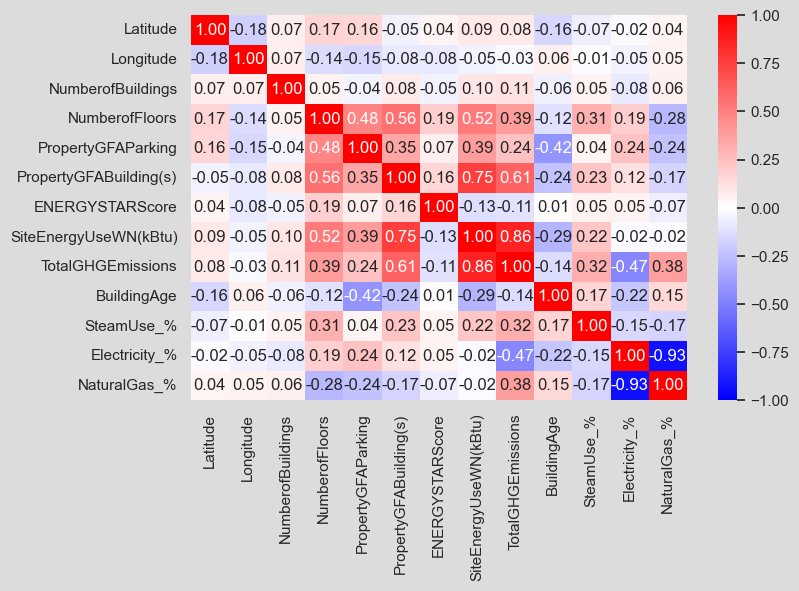

In [92]:
# use Spearman's rho for correlations as none of the variables are Gaussian
corrs_spear = data_pairs.corr(method='spearman', numeric_only=True)
fig, ax = plt.subplots(figsize=(8,5))
corrs_spear_heatmap = sns.heatmap(corrs_spear.round(2), vmin=-1, vmax=1, annot=True, cmap="bwr", fmt="0.2f", 
                                 annot_kws={"fontsize":12})
plt.savefig("spearman_heatmap.png", bbox_inches="tight")
plt.show()

**For interpretation of Spearman's rho see :**
https://www.researchgate.net/figure/Grading-table-of-Spearman-correlation-coefficient-r_tbl2_331096265

### 1.9.3 - Features most correlated to EnergyStarSCORE

In [93]:
# create list of features more strongly correlated wit the Energy Star Score
max_corrs = corrs_spear.loc[(abs(corrs_spear['ENERGYSTARScore']) >= 0.1) 
                                & (corrs_spear['ENERGYSTARScore'] < 1)].index.tolist()
max_corrs     

['NumberofFloors',
 'PropertyGFABuilding(s)',
 'SiteEnergyUseWN(kBtu)',
 'TotalGHGEmissions']

**4 variables are more strongly correlated with the Energy Star Score. We will limit the n_nearest_features to 4 when using the Iterative Imputer in the 2nd part of the analysis, in order to speed-up calculations.**

In [94]:
# save list for use in modelisation notebook
with open('ess_max_corrs.pkl', 'wb') as f:
    pickle.dump(max_corrs, f)    

# 1.10 - Export data

In [95]:
# export dataframes to csv
clean_data_all.to_csv('clean_data_all.csv', index=False)

In [96]:
# export dataframes to csv
clean_data_all_bis.to_csv('clean_data_all_bis.csv', index=False)